# Problem Set 8: Unsupervised Learning


**Release Date:** 10 November 2023

**Due Date:** 23:59, 18 November 2023

In this problem set, we will be exploring unsupervised learning for image compression and classification. In particular, we will be implementing the K-Means algorithm, exploring its use for image compression, and experimenting with various unsupervised learning algorithms (specifically, K-Means and Principle Component Analysis) for the purpose of semi-supervised classification in the absence of labelled data.

**Gentle reminder that there is penalty for using iterative method where numpy is possible. We have written down the number of loops needed in each of the task as a comment.**

_Honour Code: Note that plagiarism will not be condoned! You may discuss with your classmates and check the internet for references, but you MUST NOT submit any code/report/explanation that is copied directly from other sources!_

# Set-Up

In this section, packages and functions that are needed for the following tasks
are specified. Please ensure that all code in this section is run before running
other code snippets in this notebook.

Note that you should **NOT** modify any code in this section. However, you
might want to have a look at the helper functions specified so that you can use 
them whenever appropriate.

### Imports

The following lines of code import packages and functions that are necessary
for the following tasks.

As a reminder, please **do not** modify the following lines of code by adding,
removing or modifying the specified imports. 

In [1]:
import csv
import os

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

### Helper Functions

### 1.1 Concept - How can K-means be used to compress images?

##### Typical Image Representation

Before we attempt compressing images, let us have a look at how images used in this problem set are represented digitally. 

Suppose we have a colour image `I` that has a height of $h$ pixels and width of $w$ pixels, i.e. it contains $h \times w$ pixels. Then, it can be represented by a 3D array that has the shape $(h, w, 3)$, since each pixel has 3 values -- one for each of the RGB (red, green and blue) channels -- that determine the pixel colour. To be more specific, a pixel located at the `i`th row and `j`th column of image `I` contains `I[i][j][0]`, `I[i][j][1]` and `I[i][j][2]` amount of red, blue and green respectively, where $0 \leq$ `I[i][j][c]` $\leq 255$, with $c \in \{0, 1, 2\}$.

For example, if the pixel along the 3rd row and 5th column is black, we will have `I[3][5][0]` $=$ `I[3][5][1]` $=$ `I[3][5][2]` $= 0$; and if the pixel along the 2nd row and 1st column is white, we will have `I[2][1][0]` $=$ `I[2][1][1]` $=$ `I[2][1][2]` $= 255$.

##### Motivation for Compression

Observe that based on the above image representation, to encode the amount of red in one pixel, we need 8 bits (to represent values from 0 to 255), likewise for the green and blue channels. In other words, we will need a total of 24 bits to encode each pixel's colour. 

However, upon closer inspection, we will notice that we do not in fact need 24 bits for each pixel because the number of distinct colours in a natural image is often much less than $2^{24}$.

Moreover, the perceptible difference in colour between pixels with RGB values that only differ slightly is usually minimal. Therefore, we can afford to conflate colours with similar RGB values without a significant loss in visual quality of the image. The example in the figure below illustrates this. 

<img src="images/colour_differences.png" width="300">

##### Overview of Compression Procedure

Instead of accommodating all $2^{24}$ colours in the RGB colour space, we shall limit the possible colours to some fixed $k$, where $k \in \mathbb{N}$ and $k \geq 2$.

To select these $k$ colours from the $2^{24}$ colours in the RGB colour space, we shall use the _K-Means algorithm_, with the pixel values as input data, to find $k$ _clusters_. Then, the $k$ _centroids_ of these clusters will be the $k$ colours.

Next, every pixel $p$ in the $i$-th cluster, where $0 \leq i < k$, will be recoloured to the its centroid's value. For example, if the zeroth centroid is $[253, 0, 0]$ and $p_0 = [255, 0, 0]$ is assigned to the zeroth cluster, then in the compressed image, $p_0$ will have a value of $[253, 0, 0]$.

We can then represent the compressed image `I'` of `I` with a sequence `S` of $k$ colours, and a 2D $h \times w$ matrix, where $0 \leq $ `I'[i][j]` $< k$. Then, when rendering the image on screen, the pixel along the `i`th row and `j`th column will have the colour given by `S[I'[i][j]]`.

Notice that this proposed encoding of an image can reduce the memory requirements for storing the image because now, each pixel only needs $\lceil log_2k \rceil$ bits instead of 24 bits. Alas, the reduction is dependent on our choice of $k$ (since a larger $k$ means that we will incur a greater overhead cost for encoding `S`), and the dimensions of the image.

In [2]:
def load_rgb_image(image_file_path):
    '''
    Loads the RGB image at `image_file_path`, where the file path should be
    specified relative to this notebook, and returns the image as an `ndarray`
    with shape `(h, w, 3)`, where `h` and `w` are the height and width of the
    image respectively.

    NOTE: every entry in the returned `ndarray` is an integer between 0 and 255,
    inclusive.
    '''

    dirname = os.path.abspath('')
    image_path = os.path.join(dirname, image_file_path)
    image = mpimg.imread(image_path)
    return image

In [3]:
def display_image(image):
    '''
    Displays image that is represented by `image`, an `ndarray`.

    NOTE: if the data type of `image` is `int`, its entries should have values
    between 0 and 255 (inclusive); otherwise, its entries should have values
    between 0 and 1 (inclusive).
    '''
    plt.imshow(image)

In [4]:
def _load_digits_data(is_train):
    '''
    Loads handwritten digits dataset. 

    Parameter
    ---------
    is_train: bool
        If `is_train` is `True`, the dataset returned will be unlabelled; otherwise,
        it is labelled
  
    Returns
    -------
    An `m * n` matrix `samples`. Here, `m` is the number of samples.

    If `is_train` is `True`, then `n` is equal to `h * w`, where `h` denotes the
    image height and `w` denotes the image width.
    '''
    dirname = os.path.abspath('')
    file_name = 'digits_train.csv' if is_train else 'digits_validation.csv'
    file_path = os.path.join(dirname, file_name)
    data = []
  
    with open(file_path, mode='r') as file:
        rows = csv.reader(file)
        for row in rows:  
            data.append([int(num) for num in row])

    return np.array(data)

In [5]:
def load_digits_data_train():
    '''
    Loads the training dataset for the handwritten digits recognition problem.

    Returns
    -------
    A 2D array `digits`, where `digits[i].reshape((28, 28))` is the image of the `i`th 
    handwritten digit. This image only has one channel, i.e. every pixel is
    only represented by an intensity value rather than an RGB triplet.
    '''
    return _load_digits_data(True)

In [6]:
def load_digits_data_validation():
    '''
    Loads the validation dataset for the handwritten digits recognition problem.

    Returns
    -------
    A tuple (`digits`, `labels`). 

    `digits` is a 2D array, where `digits[i].reshape((28, 28))` is the image of 
    the `i`th handwritten digit. This image only has one channel, i.e. every pixel 
    is only represented by an intensity value rather than an RGB triplet.

    `labels` is an array where `labels[i]` returns the actual label of the `i`th
    handwritten digit in `digits`. Note that `labels[i]` is an integer such that
    0 <= `labels[i]` <= 9.
    '''
    data = _load_digits_data(False)
    digits = data[:, 1:]
    labels = data[:, 0]
    return digits, labels

In [7]:
def compute_accuracy(pred_labels, true_labels):
    '''
    Computes the accuracy of the predicted labels, given the true labels.
    '''
    return np.sum(pred_labels == true_labels) / true_labels.shape[0]

# Part 1: Image Compression

In this part of the problem set, we shall look at how we can perform lossy compression of images.

##### Example on how K-Means can be used to compress image 

The images demonstrate the use of K-Means in image compression. The original image is a shaded gradient from red to blue.

<img src="images/red_blue.jpg" width="300" height="150">

When K-Means is applied with k=30, the image is compressed into 30 different shades of color. Each shade is formed by grouping similar pixel colors together based on their proximity to each other. The result is a compressed image with 30 different color regions instead of the original gradient. The images below show the compressed image when k = 30, k = 10 and k = 2 respectively.


<img src="images/compressed_red_and_blue_k=30.png" width="300" height="150">
<img src="images/compressed_red_and_blue_k=10.png" width="300" height="150">
<img src="images/compressed_red_and_blue_k=2.png" width="300" height="150">

In summary, K-Means can be used in image compression by grouping similar pixels together and reducing the overall number of colors in an image. This technique can help to reduce file size and processing time without significantly affecting the visual quality of the image if k is chosen correctly.

### Concept - Implementing the K-Means Algorithm

We begin by implementing the K-Means algorithm which we will be using for the rest of this problem set. The K-means procedure consists of separate steps, which you are to implement step-by-step.

Please note that your solution **should work for any type of data, not only images**; and the only requirement for the efficiency of your implementation of the K-Means algorithm is that it is sufficiently fast to be used throughout this problem set, where appropriate. Lastly, as mentioned earlier, you are **NOT allowed** to import any additional packages.

##### Review of the K-Means Algorithm

Recall that the general procedure for K-Means clustering is as follows.

1. Randomly initialise k centroids, each representing the centroid of a cluster.
2. Assign each data point to the closest cluster.
3. Based on the new cluster assignment, compute and update the centroid for each cluster.
4. Repeat steps 2 and 3 until convergence.

**Gentle reminder that there is penalty for using iterative method where numpy is possible. We have written down the number of loops needed in each of the task as a comment.**

## 1.1: Implementing the K-Means Algorithm

### Task 1.1.1 Assign Points to Centroids

Our first task is to implement `assign_clusters`.

This function has two parameters `X` and `centroids`. In this case, `X` is an $m \times n$ matrix, where $m$ is the number of samples and $n$ is the number of features which each sample has; and `centroids` is an `n_clusters` $\times$ $n$ matrix -- where `n_clusters` is the number of clusters -- such that `centroids[j]` gives the $j$-th cluster's centroid. 

The purpose of this function is to assign each sample in `X` to the closest cluster. More formally, suppose the $i$-th sample is assigned to the $j$-th cluster, then the Euclidean distance $d_{i, j}$ should be such that $d_{i, j} \leq d_{i, k}$ $\forall k \in \{0, 1, 2, ..., $ `n_clusters`$-1\}$. In the event that there exists two clusters that are as close to the $i$-th sample, it should be assigned to the cluster with the smaller index, i.e. if $\exists$ $j$, $j$' such that $d_{i, j} = d_{i, j'}$, then sample $i$ should be assigned to cluster $s$, where $s = $ min($j$, $j$').

This function should then return an array `labels` such that each `labels[i]` is an **integer** indicating which cluster the $i$-th sample has been assigned to.

In [8]:
def assign_clusters(X, centroids):
    """
    Assigns each sample in X to the closest cluster.

    Parameters
    ----------
    X: np.darray
        An `m * n` matrix where `m` is the number of samples and `n` is the
        number of features which each sample has. In other words, the `i`th sample
        is given by `X[i]`.
    centroids: np.darray
        An `n_clusters * n` matrix where `n_clusters` is the number of clusters
        and `n` is the number of features which each sample has. In particular, 
        `centroids[j]` represents the `j`th cluster's centroid.

    Returns
    -------
    An `ndarray` of integers that indicates the cluster assignment for each sample.
    Specifically, if `labels` is the `ndarray` returned, then `labels[i]` indicates
    that the `i`th sample in X has been assigned to the `labels[i]`th cluster, where
    `labels[i]` is a value in the interval [0, `n_clusters`). This cluster should
    be the one with a centroid that is closest to `X[i]` in terms of its Euclidean
    distance. Note that this array should be an array of integers.

    Note
    ----
    If there are multiple possible closest clusters for the `i`th sample in X,
    assign it to the cluster with the smallest index. For example, if `X[0]` is
    as close to `centroids[0]` as it is to `centroids[1]`, it should be assigned
    to the 0th cluster instead of the 1st cluster, since 0 < 1.
    """
    # calculate distance between each sample and each centroid
    distances = np.linalg.norm(X[:, None] - centroids, axis=2)
    # find the index of the centroid that is closest to each sample
    return np.argmin(distances, axis=1)

In [11]:
# Public test case 1
X_111 = np.arange(20).reshape((5, 4))
labels_111 = assign_clusters(X_111, np.copy(X_111))

assert np.issubdtype(labels_111.dtype, int)

# Public test case 2
assert np.all(labels_111 == np.arange(5))

### Testing assignment of points to centroids

Use the code below to visualise the effect of running your cluster assignment algorithm on another set of (non-image) data. 

Note that the centroids of the data are marked by a red "$+$", and each unique colour represents a unique grouping of elements.

You should expect to see logical groupings of elements based on their distance to the nearest centroid, as specified above.

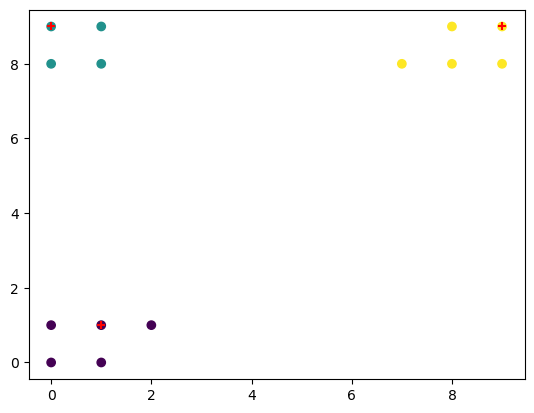

In [10]:
###############
# For testing #
###############
X_sample = np.array([
    [0, 0], [0, 1], [1, 0], [1, 1], [2, 1],
    [7, 8], [8, 8], [8, 9], [9, 8], [9, 9],
    [0, 8], [1, 8], [0, 9], [1, 9],
])
centroids = np.array([[1,1],[0,9],[9,9]])
labels = assign_clusters(X_sample, centroids)
plt.scatter(X_sample[:,0], X_sample[:,1], c=labels)
plt.scatter(centroids[:,0], centroids[:,1], marker='+', color='r')
plt.show()

### Task 1.1.2: Update Centroids

Now that we have completed implementing step 2 of the K-Means algorithm,
let us move on to step 3 by implementing `update_centroids`.

Given `X`, `labels` and `n_clusters` as inputs to this function, we need to compute the updated centroids for each cluster. Here, `labels` is such that if the sample point $i$ is assigned to the $j$-th cluster, then `labels[i]` $=$ $j$.

This function should return an `n_clusters` $\times$ $n$ matrix `centroids` such that `centroids[j]` gives the updated centroid of the $j$-th cluster.

In [9]:
def update_centroids(X, labels, n_clusters):
    '''
    Updates the centroids based on the (new) assignment of clusters.

    Parameters
    ----------
    X: np.darray
        An `m * n` matrix where `m` is the number of samples and `n` is the
        number of features which each sample has. In other words, the `i`th sample
        is given by `X[i]`.
    labels: np.darray
        An array of `m` values, where `m` is the number of samples, that indicates
        which cluster the samples have been assigned to, i.e. the `i`th
        sample is assigned to the `labels[i]`th cluster.
    n_clusters: int
        No. of clusters.

    Returns
    -------
    The `centroids`, an `ndarray` with shape `(n_clusters, n)`, for each cluster,
    based on the current cluster assignment as specified by `labels`. In particular,
    `centroids[j]` returns the centroid for the `j`th cluster.
    '''
    # initialize centroids
    # for i in range(n_clusters):
    #     centroids[i] = np.mean(X[labels == i], axis=0)
    # initialize centroids
    sums = np.zeros((n_clusters, X.shape[1]))
    # number of samples in each cluster
    counts = np.bincount(labels, minlength=n_clusters)
    # sum up everything in each cluster
    np.add.at(sums, labels, X)
    # Avoid division by zero
    counts[counts == 0] = 1
    # Calculate the mean
    centroids = sums / counts[:, None]
    return centroids

In [20]:
# Public test case 1
output_112 = update_centroids(np.array([[1, 2, 3], [1, 2, 3], [5, 2, 100], [1, 2, 3], [5, 2, 100], [5, 2, 100], [1, 2, 3]]), np.array([0, 0, 1, 0, 1, 1, 0]), 2)
expected_112 = np.array([[1, 2, 3], [5, 2, 100]])
assert np.all(output_112 == expected_112)

[[0. 0. 0.]
 [0. 0. 0.]]


### Testing updating of centroids

Use the code below to visualise the effect of updating existing centroids.

The overall assignment of the clusters for each individual point should remain the same, but the location of the centroid should be more "centralised" to each logical grouping of points.

In [13]:
###############
# For testing #
#
# The image generated shows the position of the old centroids and the new centroids #
###############
new_centroids = update_centroids(X_sample, labels, len(centroids))
plt.scatter(X_sample[:,0], X_sample[:,1], c=labels)
plt.scatter(centroids[:,0], centroids[:,1], marker='+', color='r', label='old centroids')
plt.scatter(new_centroids[:,0], new_centroids[:,1], marker='x', color='g', label='new centroids')
plt.legend(loc="lower right")
plt.show()

NameError: name 'X_sample' is not defined

### Task 1.1.3: Check for Convergence
Next, let us implement the function `check_convergence`, which returns true if and only if the convergence conditions are met.

Notice that this function has the parameters `prev_centroids` and `centroids`. The difference between `prev_centroids` and `centroids` is that the latter indicates the centroids that have been found in the current iteration while the former indicates those of the previous iteration.

In addition, this function also has the `threshold` parameter which determines the convergence criteria, as described in the next paragraph.

In this case, convergence is met when for each cluster $j$, the Euclidean distance between its current centroid and previous centroid is __strictly less than__ `threshold`.

In [10]:
def check_convergence(prev_centroids, centroids, threshold):
    '''
    Checks whether the algorithm has converged.

    Parameters
    ----------
    prev_centroids: np.darray
        An `n_clusters * n` matrix where `n_clusters` is the number of clusters
        and `n` is the number of features which each sample has. In particular, 
        `prev_centroids[j]` represents the `j`th cluster's centroid in the
        PREVIOUS iteration.
    centroids: np.darray
        An `n_clusters * n` matrix where `n_clusters` is the number of clusters
        and `n` is the number of features which each sample has. In particular, 
        `centroids[j]` represents the `j`th cluster's centroid in the CURRENT
        iteration.
    threshold: double
        If each cluster is such that the Euclidean distance between its centroids
        in the current and previous iteration is strictly less than `threshold`,
        the algorithm is deemed to have converged.

    Returns
    -------
    `True` if and only if the Euclidean distance between each
    cluster's centroid in the previous and current iteration is strictly
    less than `threshold`.
    '''
    return np.all(np.linalg.norm(prev_centroids - centroids, axis=1) < threshold)

In [23]:
# Public test case 1
assert not check_convergence(np.array([[0, 0, 0], [1, 0, 0]]), np.array([[0, 100, 0], [20, 0, 0.009]]), 0.01)

# Public test case 2
assert check_convergence(np.array([[0, 0, 0], [1, 0, 0]]), np.array([[0, 0.001, 0], [1.0002, 0, 0.009]]), 0.01)

###############
# For testing #
###############
print( check_convergence(centroids, new_centroids, .1) ) # False
print( check_convergence(centroids, new_centroids, .5) ) # False
print( check_convergence(centroids, new_centroids, 10) ) # True

False
False
True


### Task 1.1.4: Performing K-Means Once
Let us put together what we have done so far by implementing the function `k_means_once`!

This function takes `X`, `initial_centroids` and `threshold` as arguments. Here, `initial_centroids` is an `n_clusters` $\times$ $n$ matrix such that `initial_centroids[j]` is the centroid of the initial cluster $j$.

It then returns two values, the cluster assignment and the centroid of each cluster, respectively. In other words, we expect

`labels, centroids = k_means_once(X, initial_centroids, threshold)`

where `labels[i]`, for $0 \leq i < m$, is the cluster assignment for the $i$-th sample in `X`, and `centroids[j]` is the centroid of the $j$-th cluster, after K-Means clustering is done.

In [11]:
def k_means_once(X, initial_centroids, threshold):
    '''
    Assigns each point in X to a cluster by running the K-Means algorithm
    once till convergence.

    Parameters
    ----------
    X: np.darray
        An `m * n` matrix where `m` is the number of samples and `n` is the
        number of features which each sample has. In other words, the `i`th sample
        is given by `X[i]`.
    initial_centroids: np.darray
        An `n_clusters * n` matrix, where `n_clusters` is the number of clusters and
        `n` is the number of features that each sample in X has. This matrix is such
        that the `i`th row represents the initial centroid of the `i`th cluster.
    threshold: double
        During the clustering process, if the difference in centroids between
        two consecutive iterations is less than `threshold`, the algorithm is
        deemed to have converged.

    Returns
    -------
    The cluster assignment for each sample, and the `n_clusters` centroids found. 
    In particular, the cluster assignment for the ith sample in `X` is given by `labels[i]`,
    where 0 <= `labels[i]` < `n_clusters`. Moreover, suppose c = `labels[i]`. Then,
    the `i`th sample belongs to the cluster c with the centroid given by `centroids[c]`.
    '''
    centroids = initial_centroids
    prev_centroids = np.zeros(centroids.shape)
    
    while not check_convergence(prev_centroids, centroids, threshold):
        prev_centroids = centroids.copy()

        labels = assign_clusters(X, centroids)

        centroids = update_centroids(X, labels, initial_centroids.shape[0])

    return labels, centroids

In [37]:
# Public test case 1
intial_centroids_114_1 = np.array([[1, 0, 2], [-100, 200, 300]])
X_114_1 = np.array([ [-9.72926939e+01, 2.01498559e+02, 3.02113436e+02], [-9.98584016e+01, 2.00621416e+02, 3.03353122e+02], [-9.67640524e+01, 2.03076926e+02, 3.01918388e+02], [ 5.98604968e+00, 4.90417669e+00, 5.42770992e+00], [ 4.25229638e+00, 3.44223365e+00, 3.94460712e+00],[ 1.67548253e+00, 3.60744170e+00, 4.62677161e+00], [ 2.55120938e+00, 2.42917679e+00, 6.44743917e+00], [ 5.67021758e+00, 1.78897598e+00, 4.85764915e+00], [ 2.60934696e+00, 2.97150015e+00, 3.68955613e+00], [-9.80419050e+01, 2.04451372e+02, 3.01135788e+02], [-9.68840643e+01, 2.00420077e+02, 3.04163221e+02], [-9.60645085e+01, 2.01196847e+02, 3.04382421e+02], [-9.97071598e+01, 2.01680585e+02, 3.00751397e+02], [-9.77483032e+01, 2.03981621e+02, 3.01153211e+02], [-9.97398935e+01, 2.02022759e+02, 3.00992565e+02], [-9.95462348e+01, 2.02901662e+02, 3.01493481e+02], [-9.66400256e+01, 2.00997577e+02, 3.04710566e+02], [-9.81744492e+01, 2.00527476e+02, 3.03145541e+02], [-9.53642272e+01, 2.02201886e+02, 3.04772952e+02], [-9.75005209e+01, 2.02126143e+02, 3.03101067e+02], [ 5.97548253e+00, 4.74471837e+00, 4.30022570e+00], [-9.62113558e+01, 2.02487113e+02, 3.02646561e+02], [-9.60710715e+01, 2.02073279e+02, 3.03672418e+02], [ 4.55571439e+00, 4.66029843e+00, 2.57466317e+00], [ 4.64507559e+00, 4.63711964e+00, 6.83963095e+00], [-9.99264685e+01, 2.04318200e+02, 3.04905975e+02], [-9.52139491e+01, 2.00743820e+02, 3.04863144e+02], [ 5.44967778e+00, 4.11186914e+00, 4.39993962e+00], [-9.88381354e+01, 2.04009403e+02, 3.04617651e+02],[-9.86693486e+01, 2.02694672e+02, 3.02213764e+02], [-9.53449134e+01, 2.00202554e+02, 3.03660031e+02], [4.07186623e+00, 1.41826826e-01, 5.59609886e+00], [1.07995865e+00, 3.78975501e+00, 4.56379362e+00]])
output_114_1, _ = k_means_once(X_114_1, intial_centroids_114_1, 0.1)
expected_114_1 = np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0])

assert np.all(output_114_1 == expected_114_1)

# Public test case 2
intial_centroids_114_2 = np.array([[1, 0, 2, 32, 4], [-100, 200, 300, 150, -128], [1000, 150, -20, 500, -10]])
X_114_2 = np.array([[ 1.56491720e+00, 7.37381262e-01, 6.74026762e+00, 3.61723171e+01, 7.12403246e+00], [ 3.99284910e+00, 2.84387038e-01, 2.25724207e+00, 3.44348858e+01, 5.48927846e+00], [-9.69068153e+01, 2.04992404e+02, 3.01872102e+02, 1.51655272e+02, -1.27365154e+02], [-9.71911561e+01, 2.03214951e+02, 3.02305517e+02, 1.50122215e+02, -1.24891304e+02], [-9.84892927e+01, 2.04022064e+02, 3.00511482e+02, 1.50949813e+02, -1.23514390e+02], [-9.91883972e+01, 2.03602966e+02, 3.02670367e+02, 1.53879734e+02, -1.25370461e+02], [ 2.15315930e+00, 2.33996767e+00, 2.03527496e+00, 3.32534705e+01, 8.63696144e+00], [ 1.00452684e+03, 1.51308844e+02,-1.91088647e+01, 5.03463870e+02, -6.92172061e+00], [ 1.00085330e+03, 1.53669237e+02,-1.56212784e+01, 5.00843984e+02, -5.50511348e+00], [ 1.51751682e+00, 5.56468924e-01, 2.81213650e+00, 3.32390654e+01, 8.50429903e+00], [ 1.82309225e+00, 4.90897221e-01, 5.53413182e+00, 3.22724318e+01, 5.49885178e+00], [-9.84314061e+01, 2.01608694e+02, 3.04407217e+02, 1.51907009e+02, -1.23924059e+02], [ 2.92258291e+00, 1.04948810e+00, 3.18654930e+00, 3.22594379e+01, 6.51531796e+00], [-9.97080699e+01, 2.00483592e+02, 3.02897705e+02, 1.54860298e+02, -1.24697593e+02], [ 1.00295696e+03, 1.51894953e+02,-1.55318935e+01, 5.01907666e+02, -9.58991427e+00], [-9.72025657e+01, 2.04930408e+02, 3.01296162e+02, 1.54463456e+02, -1.25405463e+02], [-9.98900358e+01, 2.01951120e+02, 3.03069414e+02, 1.52185855e+02, -1.23697303e+02], [ 1.00485325e+03, 1.50588049e+02,-1.61681193e+01, 5.00208238e+02, -5.19900895e+00], [ 1.00162638e+03, 1.54835658e+02,-1.78113123e+01, 5.03155981e+02, -5.41095710e+00], [-9.99262989e+01, 2.01734123e+02, 3.04372332e+02, 1.51584896e+02, -1.26046111e+02], [ 1.00268952e+03, 1.51464525e+02,-1.87672043e+01, 5.03205192e+02, -7.01124970e+00], [ 1.00304660e+03, 1.54898230e+02,-1.94315847e+01, 5.02473927e+02, -9.07506503e+00], [ 5.72555017e+00, 2.21871100e+00, 5.60023390e+00, 3.57522016e+01, 5.42109897e+00], [ 1.00201639e+03, 1.52022011e+02,-1.58161709e+01, 5.01134304e+02, -8.99219657e+00], [-9.59006093e+01, 2.00043326e+02, 3.02233922e+02, 1.53674545e+02, -1.24757694e+02], [-9.73563260e+01, 2.02452060e+02, 3.03398007e+02, 1.51560495e+02, -1.25232723e+02], [-9.52311306e+01, 2.04100698e+02, 3.00158417e+02, 1.52744470e+02, -1.24073020e+02], [ 1.00209939e+03, 1.54618209e+02,-1.77651413e+01, 5.02467660e+02, -6.78368846e+00], [ 1.00350617e+03, 1.53013154e+02,-1.85411405e+01, 5.01362388e+02, -6.06756023e+00], [-9.68708151e+01, 2.04948821e+02, 3.01200395e+02, 1.52091351e+02, -1.24405273e+02], [ 1.00426189e+03, 1.52252591e+02,-1.66751292e+01, 5.04040696e+02, -6.93514438e+00], [ 1.00056503e+03, 1.52710502e+02,-1.75870621e+01, 5.04588456e+02, -7.64625156e+00], [ 1.00434411e+03, 1.53118866e+02,-1.75201216e+01, 5.01171910e+02, -6.41971954e+00], [ 1.00447310e+03, 1.54898691e+02,-1.80266001e+01, 5.01731525e+02, -8.49464067e+00], [ 1.17401540e+00, 2.00969872e+00, 4.61992013e+00, 3.45662014e+01, 8.73557856e+00], [ 1.00398066e+03, 1.53452624e+02,-1.92830333e+01, 5.02119668e+02, -9.93636756e+00], [ 1.00243798e+03, 1.51927175e+02,-1.59887628e+01, 5.02110072e+02, -8.55139135e+00], [-9.78056355e+01, 2.00998191e+02, 3.03530065e+02, 1.53873608e+02, -1.26466762e+02], [ 1.00103397e+03, 1.52399510e+02,-1.67024619e+01, 5.02323216e+02, -8.32458928e+00], [-9.69470516e+01, 2.04320439e+02, 3.01198535e+02, 1.53765658e+02, -1.27862417e+02], [-9.97896159e+01, 2.02641681e+02, 3.00014716e+02, 1.53307670e+02, -1.26516157e+02], [ 1.00290761e+03, 1.53036753e+02,-1.63533704e+01, 5.03202986e+02, -9.34091385e+00], [ 1.00254891e+03, 1.54517630e+02,-1.74044743e+01, 5.03481636e+02, -6.31593142e+00], [-9.89251000e+01, 2.02110923e+02, 3.00125395e+02, 1.54144876e+02, -1.24536347e+02], [ 1.48246410e+00, 2.31907552e+00, 5.10935695e+00, 3.56577529e+01, 8.42158349e+00], [ 2.39698975e+00, 3.68390714e+00, 6.51639124e+00, 3.30049071e+01, 5.18650548e+00], [-9.55947307e+01, 2.04884666e+02, 3.02226645e+02, 1.51312246e+02, -1.27759747e+02], [ 1.00363194e+03, 1.53067050e+02,-1.60493725e+01, 5.00660091e+02, -5.99451690e+00], [-9.61151926e+01, 2.03094310e+02, 3.00117847e+02, 1.53942660e+02, -1.25748154e+02], [ 4.87809265e+00, 3.91657243e+00, 6.29320750e+00, 3.65373345e+01, 6.83891257e+00], [ 1.00330495e+03, 1.52184344e+02,-1.53334017e+01, 5.04613027e+02, -7.97179155e+00], [ 1.00376830e+03, 1.51041189e+02,-1.59458846e+01, 5.01900942e+02, -9.64050948e+00], [ 1.00177926e+03, 1.53088579e+02,-1.92474048e+01, 5.02769755e+02, -6.67230911e+00], [ 5.42322619e+00, 3.29985315e+00, 3.84925530e+00, 3.56765310e+01, 8.12679837e+00], [-9.87394670e+01, 2.04224169e+02, 3.03990890e+02, 1.53551472e+02, -1.23338799e+02]])
output_114_2, _ = k_means_once(X_114_2, intial_centroids_114_2, 0.1)
expected_114_2 = np.array([0, 0, 1, 1, 1, 1, 0, 2, 2, 0, 0, 1, 0, 1, 2, 1, 1, 2, 2, 1, 2, 2, 0, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2,  1, 2, 1, 1, 2, 2, 1, 0, 0, 1, 2, 1, 0, 2, 2, 2, 0, 1,])

assert np.all(output_114_2 == expected_114_2)

[[0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


[[0. 0.]
 [0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]
 [0. 0.]]


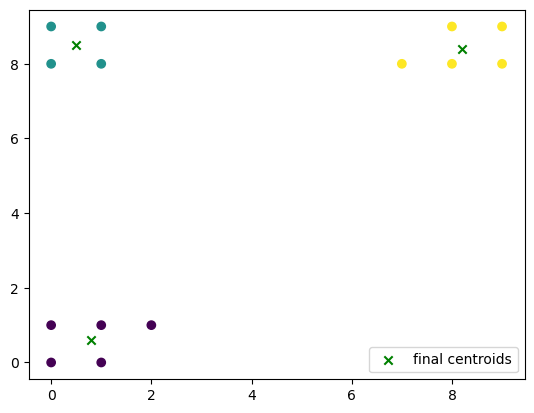

In [38]:
###############
# For testing #
###############
final_labels, final_centroids = k_means_once(X_sample, centroids, .1)
plt.scatter(X_sample[:,0], X_sample[:,1], c=final_labels)
plt.scatter(final_centroids[:,0], final_centroids[:,1], marker='x', color='g', label='final centroids')
plt.legend(loc="lower right")
plt.show()

### Task 1.1.5: Computing Loss
Generally, the K-Means algorithm is non-deterministic, as its solution depends on our choice of initial centroids, which is usually randomly initialised. Therefore, it is possible for solutions from certain runs of the algorithm to outperform the others. One way to determine how 'good' a solution is involves evaluating the *loss function*

\begin{equation}
    J(c^{(0)},..., c^{(m - 1)}, \mu_1, ..., \mu_K) = \frac{1}{m} \sum_{i=0}^{m-1} \lVert x^{(i)} - \mu_{c^{(i)}} \rVert ^2
\end{equation}

where $K$ is the number of clusters, $x^{(i)}$ is the $i$-th sample's value, $c^{(i)}$ is the cluster which the $i$th sample is assigned to, and $\mu_j$ is the $j$-th cluster's centroid. For example, if there are only two clusters, where the zeroth cluster's centroid is $\mu_0$ and the first cluster's centroid is $\mu_1$, and there are three sample points $x^{(0)}$, $x^{(1)}$ and $x^{(2)}$ such that the first two points are assigned to the zeroth cluster while the last point is assigned to the first cluster, then we have
\begin{equation}
\begin{split}
    & J(c^{(0)}, c^{(1)}, c^{(2)}, \mu_0, \mu_1)\\
    &= \frac{1}{3} \Big[\lVert x^{(0)} - \mu_{c^{(0)}} \rVert ^2 + \lVert x^{(1)} - \mu_{c^{(1)}} \rVert ^2
        + \lVert x^{(2)} - \mu_{c^{(2)}} \rVert ^2\Big]\\
    &= \frac{1}{3} \Big[\lVert x^{(0)} - \mu_0 \rVert ^2 + \lVert x^{(1)} - \mu_0 \rVert ^2
        + \lVert x^{(2)} - \mu_1 \rVert ^2\Big]
\end{split}
\end{equation}
since $c^{(0)}$ = 0, $c^{(1)}$ = 0, and $c^{(2)}$ = 1.

In particular, we can deem a solution of the K-Means algorithm to be 'better' when it gives a lower loss value. Intuitively, we can see that the loss value is lower when the data points are closer to the centroids which they have been assigned to.

Therefore, it is meaningful for us to implement `compute_loss`, which returns the loss of the solution given by `centroids` and `labels` for `X`.


In [12]:
def compute_loss(X, centroids, labels):
    '''
    Computes the loss based on the current assignment of clusters.

    Parameters
    ----------
    X: np.darray
        An `m * n` matrix where `m` is the number of samples and `n` is the
        number of features which each sample has. In other words, the `i`th sample
        is given by `X[i]`.
    centroids: np.darray
        An `n_clusters * n` matrix where `n_clusters` is the number of clusters
        and `n` is the number of features which each sample has. In particular, 
        `centroids[j]` represents the `j`th cluster's centroid.
    labels: np.darray
        An array of `m` values, where `m` is the number of samples, that indicates
        which cluster the samples have been assigned to,  i.e. `labels[i]` indicates
        that the `i`th sample is assigned to the `labels[i]`th cluster.
  
    Returns
    -------
    The loss based on the current assignment of clusters.
    '''
    diff = X[:, None] - centroids
    # take the centroid that the sample is assigned to
    diff = diff[np.arange(len(labels)), labels]
    # sum up the squared difference, divide by the number of features
    return np.sum(diff ** 2) / X.shape[0]

In [75]:
# Public test case 1
assert compute_loss(np.array([ [3, 4, 0], [33, 6.5, 50], [0, 0.3, 0.4], [30, 2.8, 50.4], [30.3, 2.9, 50] ]), 
                    np.array([[0, 0, 0], [30, 2.5, 50]]), 
                    np.array([0, 1, 0, 1, 1])) == 10.15

###############
# For testing #
###############
compute_loss(X_sample, final_centroids, final_labels) # 0.7142857142857144

[[3.  4.  0. ]
 [3.  4.  0. ]
 [0.  0.3 0.4]
 [0.  0.3 0.4]
 [0.3 0.4 0. ]]
[[-0.8 -0.6]
 [-0.8  0.4]
 [ 0.2 -0.6]
 [ 0.2  0.4]
 [ 1.2  0.4]
 [-1.2 -0.4]
 [-0.2 -0.4]
 [-0.2  0.6]
 [ 0.8 -0.4]
 [ 0.8  0.6]
 [-0.5 -0.5]
 [ 0.5 -0.5]
 [-0.5  0.5]
 [ 0.5  0.5]]


0.7142857142857143

### Task 1.1.6: Finding Better Clusters
The following code snippet `init_centroids` is used to select the initial centroids. You
**MUST** use it in your implementation for this task, as mentioned in the problem statement. **DO NOT** modify `init_centroids` in any way as it might result in inconsistencies in the testing of your code.

In [13]:
def init_centroids(X, n_clusters, random_state):
    '''
    Initialises the centroids that will be used for K-Means, by randomly
    picking `n_clusters` points from `X` and using these points as the 
    initial centroids.

    Parameters
    ----------
    X: np.darray
        An `m * n` matrix where `m` is the number of samples and `n` is the
        number of features which each sample has. In other words, the `i`th sample
        is given by `X[i]`.
    n_clusters: int
        No. of clusters.
    random_state: int or `None`
        Used to make the algorithm deterministic, if specified.

    Returns
    -------
    An `ndarray` with the shape `(n_clusters, n)` such that the `i`th row
    represents the `i`th randomly chosen centroid.
    '''
    # no loop allowed
    rng = np.random.default_rng(random_state)
    n_samples = X.shape[0]
    sample_indices = rng.permutation(n_samples)[:n_clusters]
    return X[sample_indices]

To complete our implementation of the K-Means algorithm, let us implement `k_means` using the various functions that we have previously implemented.

This function is very similar to that in task 1.1.4. However, instead of returning the cluster assignments and centroids after performing K-Means clustering once, we will perform clustering for `n_init` times, where `n_init` $\geq 1$, giving us `n_init` solutions. We will then choose the best solution (i.e. the one with the lowest loss), and return its cluster assignment and centroids.

To choose the initial centroids, you **MUST** use `init_centroids` provided above. This function takes `X`, `n_clusters` and `random_state` as inputs, where `random_state` is used to make the initialisation process deterministic, if its value is specified. The output `centroids` of this function is such that `centroids[j]` gives the initial centroid of the $j$-th cluster.

In addition, you are to implement your solution between the `""" YOUR CODE HERE """` and `""" END YOUR CODE HERE """` comments, and **NOT** to modify the rest of the given code.

In [14]:
def k_means(X, n_clusters, threshold, n_init=1, random_state=None):
    '''
    Clusters samples in X using the K-Means algorithm.

    Parameters
    ----------
    X: np.darray
        An `m * n` matrix where `m` is the number of samples and `n` is the
        number of features which each sample has. In other words, the `i`th sample
        is given by `X[i]`.
    n_clusters: int
        No. of clusters.
    threshold: float
        Threshold that determines when the algorithm should terminate. If between
        two consecutive iterations the cluster centroids' difference is less than
        `threshold`, terminate the algorithm, i.e. suppose `c_i` is the ith
        centroid in the kth iteration, and `c'_i` is the ith centroid in the
        (k + 1)th iteration, we terminate the algorithm if and only if for all  
        i, d(`c_i`, `c'_i`) < `threshold`, where d is the distance function.
    n_init: int
        No. of times to run K-means.
    random_state: int or `None`
        Used to make the algorithm deterministic, if specified.
  
    Returns
    -------
    The cluster assignment for each sample, and the `n_clusters` centroids found. 
    In particular, the cluster assignment for the ith sample in `X` is given by `labels[i]`,
    where 0 <= `labels[i]` < `n_clusters`. Moreover, suppose c = `labels[i]`. Then,
    the `i`th sample belongs to the cluster c with the centroid given by `centroids[c]`.

    If `n_init` > 1, then the labels and corresponding centroids that result in
    the lowest distortion will be returned.

    Note
    ----
    If `n_init` is greater than 1, the labels and centroids found from the run
    (out of `n_init` runs) which gives the lowest distortion will be used.
    '''
    best_centroids, best_labels = None, None
    lowest_loss = np.inf

    for i in range(n_init):
        curr_random_state = None if random_state is None else random_state + i
        initial_centroids = init_centroids(X, n_clusters, curr_random_state)
        labels, centroids = k_means_once(X, initial_centroids, threshold)
        loss = compute_loss(X, centroids, labels)
        if loss < lowest_loss:
            lowest_loss = loss
            best_labels, best_centroids = labels, centroids
  
    return best_labels, best_centroids

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[ 2.16919987e-01 -3.34397793e-01 -4.58144510e-01]
 [-4.03514063e-01  2.09085737e-01  4.13637550e-01]
 [ 1.86594077e-01  1.25312057e-01  4.45069600e-02]
 [ 2.79028313e-01  2.44980867e-01 -4.21879890e-01]
 [ 2.01360173e-01 -5.37287103e-01  3.05037060e-01]
 [-4.80388487e-01  2.92306237e-01  1.16842830e-01]
 [-4.67482033e-02 -6.96425067e-02 -5.29253370e-01]
 [-2.22176813e-01  1.78294683e-01  8.96164700e-02]
 [ 2.68925017e-01 -1.08652177e-01  4.39636900e-01]
 [ 1.83911870e-01  1.52269407e-01  2.85193390e-01]
 [-1.08476740e-01 -1.44351153e-01 -2.30169380e-01]
 [-7.54351300e-02 -7.91825333e-03 -5.50240100e-02]
 [ 3.39130400e-03  3.17741704e-01  3.22480048e-01]
 [-1.24648856e-01 -2.16296000e-04 -2.89694082e-01]
 [ 1.11855974e-01 -2.33834896e-01 -2.19944472e-01]
 [ 4.07830294e-01 -3.44588536e-01  1.16236680e-02]
 

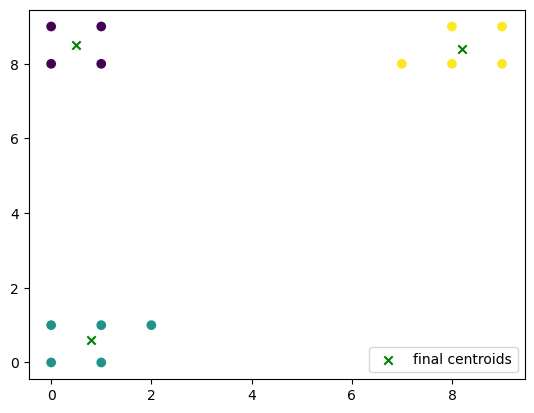

In [78]:
# Public test case 1
X_116 = np.array([[0.63696169,0.26978671,0.04097352], [0.01652764,0.81327024,0.91275558], [0.60663578,0.72949656,0.54362499], [2.93507242,2.81585355,2.0027385 ], [2.85740428,2.03358558,2.72965545], [2.17565562,2.86317892,2.54146122], [4.29971189,4.42268722,4.02831967], [4.12428328,4.67062441,4.64718951], [4.61538511,4.38367755,4.99720994], [6.98083534,6.68554198,6.65045928], [6.68844673,6.38892142,6.13509651], [6.72148834,6.52535432,6.31024188], [8.48583536,8.88948783,8.93404352], [8.3577952 ,8.57152983,8.32186939], [8.59430003,8.33791123,8.391619 ], [8.89027435,8.22715759,8.62318714], [8.08401534,8.83264415,8.78709831]])
output_labels_116, output_centroids_116 = k_means(X_116, 5, 0.001, n_init=5, random_state=2)
expected_labels_116 = np.array([4, 4, 4, 0, 0, 0, 2, 2, 2, 3, 3, 3, 1, 1, 1, 1, 1])
assert np.all(output_labels_116 == expected_labels_116)

# Public test case 2
expected_centroids_116 = np.array([[2.65604411, 2.57087268, 2.42461839], [8.48244406, 8.57174613, 8.61156347], [4.34646009, 4.49232973, 4.55757304], [6.79692347, 6.53327258, 6.36526589], [0.4200417, 0.6041845, 0.49911803]])
diff = np.abs(output_centroids_116 - expected_centroids_116)
assert np.all(diff < 0.00001)

###############
# For testing #
###############
n_clusters = 3 # feel free to try other values
final_labels, final_centroids = k_means(X_sample, n_clusters, .1, n_init=5)
plt.scatter(X_sample[:,0], X_sample[:,1], c=final_labels)
plt.scatter(final_centroids[:,0], final_centroids[:,1], marker='x', color='g', label='final centroids')
plt.legend(loc="lower right")
plt.show()

### Testing the Implementation in 3D

The following code has been added purely for your convenience. You **DO NOT** 
have to use it, if you choose not to.

In [79]:
def visualise_clusters(X, labels):
    '''
    Visualises the clusters of `X`, with `labels` indicating the cluster which
    each sample point in `X` belongs to. 

    Parameters
    ----------
    X: np.darray
        An `m * n` matrix where `m` is the number of samples and `n` is the
        number of features which each sample has. In other words, the `i`th sample
        is given by `X[i]`.
    labels: np.darray
        An array of `m` values, where `m` is the number of samples, that indicates
        which cluster the samples have been assigned to,  i.e. `labels[i]` indicates
        that the `i`th sample is assigned to the `labels[i]`th cluster.

    Note
    ----
    This function only works for `n` = 2 or 3. In addition, to ensure that the
    clusters are easily visually discernible, the visualisation only works
    with 5 or fewer clusters.
    '''
    n_axes = X.shape[1]
    if n_axes > 3:
        raise Exception('Unable to visualise clusters with more than 3 dimensions')
  
    COLOURS = np.array([[220,20,60], [255,140,0], [153,102,255],\
        [51,204,51], [30,144,255]]) / 255

    if np.any(labels >= COLOURS.shape[0]):
        raise Exception('Unable to display more than 5 clusters')

    c = COLOURS[labels] 

    fig = plt.figure()
    ax = None

    if n_axes < 3:
        ax = fig.add_subplot()
        ax.scatter(X[:, 0], X[:, 1], c=c)
    else:
        ax = fig.add_subplot(projection='3d')
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=c)

    ax.set_xlabel('Axis 0')
    ax.set_ylabel('Axis 1')

    if n_axes == 3:
        ax.set_zlabel('Axis 2')

    plt.show()
    return

def generate_synthetic_data(n_samples, n_features, n_clusters, random_state=None):
    '''
    Generates synthetic data that contain `n_samples`, where each sample has
    `n_features` and belongs to one of the `n_clusters` clusters. If `random_state`
    is not `None`, the data generated will be deterministic.
    '''
    if n_features < 1:
        raise Exception('At least one feature is needed to create the synthetic dataset.')
    elif n_clusters < 2:
        raise Exception('There should be at least 2 clusters.')
    elif n_samples < n_clusters:
        raise Exception('No. of samples should not be less than the no. of clusters.')

    samples = np.zeros((n_samples, n_features))
    cluster_means = np.tile(np.arange(n_clusters) * 2, n_features)
    n_samples_in_cluster = n_samples // n_clusters

    rng = np.random.default_rng(random_state)

    for i in range(n_clusters):
        is_last_cluster = i == (n_clusters - 1)
        start_index = i * n_samples_in_cluster
        end_index = n_samples if is_last_cluster else (i + 1) * n_samples_in_cluster
        samples[start_index:end_index] = rng.uniform(cluster_means[i],\
            cluster_means[i] + 1, (end_index-start_index, n_features))

    return samples

A simple test case for your K-Means algorithm.

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[ 2.16919988e-01 -3.34397791e-01 -4.58144507e-01]
 [-4.03514064e-01  2.09085735e-01  4.13637546e-01]
 [ 1.86594076e-01  1.25312056e-01  4.45069606e-02]
 [ 2.79028317e-01  2.44980870e-01 -4.21879889e-01]
 [ 2.01360170e-01 -5.37287109e-01  3.05037057e-01]
 [-4.80388486e-01  2.92306238e-01  1.16842831e-01]
 [-4.67482023e-02 -6.96425089e-02 -5.29253368e-01]
 [-2.22176816e-01  1.78294685e-01  8.96164721e-02]
 [ 2.68925019e-01 -1.08652176e-01  4.39636896e-01]
 [ 1.83911869e-01  1.52269408e-01  2.85193391e-01]
 [-1.08476739e-01 -1.44351153e-01 -2.30169381e-01]
 [-7.54351297e-02 -7.91825450e-03 -5.50240101e-02]
 [ 3.39130257e-03  3.17741708e-01  3.22480044e-01]
 [-1.24648860e-01 -2.16295625e-04 -2.89694081e-01]
 [ 1.11855974e-01 -2.33834901e-01 -2.19944471e-01]
 [ 4.07830296e-01 -3.44588533e-01  1.16236727e-02]
 

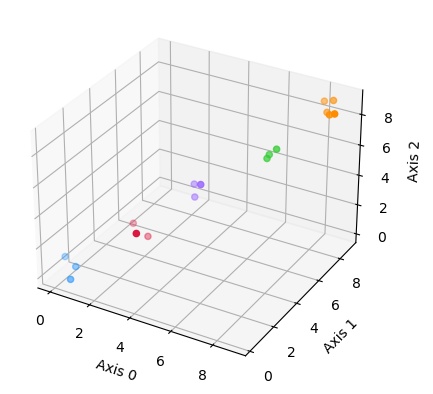

In [80]:
N_CLUSTERS = 5
X = generate_synthetic_data(17, 3, N_CLUSTERS, random_state=0)
labels, _ = k_means(X, N_CLUSTERS, 0.001, n_init=5, random_state=2)
visualise_clusters(X, labels)

<img src="images/kmeans_result_annotated.png" width="300">

The diagram is the expected result after running the test case above. Note that points that belong to the same cluster are of the same colour. Moreover, in this diagram, for clarity, red circles have been drawn in to demarcate the different clusters as well. The diagram generated by the test case will not have the red circles.

## Part 1.2: Performing Compression

### Task 1.2.1: Compress Image

Now that we have done the hard work of implementing the K-Means algorithm, let us use it to compress images using the method described in 'Overview of Compression Procedure'.

## Specifying Image File Path

`IMAGE_FILE_PATH` specifies the file path of the image that is to be compressed,
relative to this notebook. Its default value is set to 'images/teddy_bear.jpg'.
However, please feel free to update it with your own image.

In [15]:
IMAGE_FILE_PATH = 'images/teddy_bear.jpg'

## Displaying Image Before Compression

Let us have a look at the image before compression.

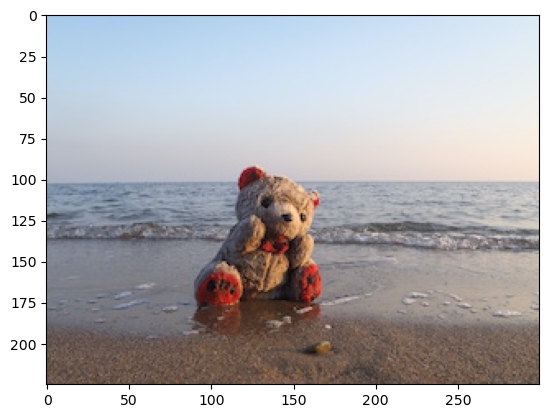

In [16]:
display_image(load_rgb_image(IMAGE_FILE_PATH))

## Defining the Image Compression Algorithm

The final task of part 1 of this problem set is to implement `compress_image`, which returns the result of the image after it has been compressed.

To be specific, this function accepts `image`, `n_colours`, `threshold`, `n_init` and `random_state` as inputs. 
- `image` is a 3D array that represents the image to be compressed, with **integral entries** between 0 and 255, inclusive; 
- `n_colours` is the number of colours that the compressed image should contain; 
- `threshold` is a positive numerical value that determines the termination condition of the K-Means algorithm; 
- `n_init` specifies the number of times to run the K-Means algorithm before selecting the best centroids and cluster assignments for compressing the image; and 
- `random_state` determines the random state of the K-Means algorithm.

It then returns a 3D array which represents the compressed image after recolouring every pixel to one of the `n_colours` colours that were 'picked' by the K-Means algorithm (i.e. the centroids of the clusters returned by the algorithm). As with the input `image`, the returned 3D array should have integral entries between 0 and 255, inclusive.


**IMPORTANT**: you **MUST** call `k_means` with the given `random_state` and `threshold`. This allows us to easily reproduce the result which you have obtained whenever necessary.

**NOTE**: It is possible for `compress_image` to take some time to complete running, especially for bigger images and larger values of `n_colours`. As long as your solution does not cause the test cases for task 1.1.6 to fail on Coursemology, you can assume that your solution is reasonably efficient.

In [17]:
def compress_image(image, n_colours, threshold, n_init=1, random_state=None):
    '''
    Compresses the given image by reducing the number of colours in the image to
    `n_colours`. The `n_colours` colours should be selected using `k_means`.

    Parameters
    ----------
    image: np.darray
        The image to be compressed. It should be an `h * w * 3` array, where `h` and
        `w` are its height and width of, with integer entries.
    n_colours: int
        No. of colours that the compressed image should contain.
    threshold: double
        A positive numerical value that determines the termination condition of the
        K-Means algorithm. You MUST call `k_means` with this threshold.
    n_init: int
        No. of times to run the K-Means algorithm before the best solution is
        picked and used for compression.
    random_state: int or `None`
        Used to make the algorithm deterministic, if specified. You MUST call
        `k_means` with `random_state` to ensure reproducility.

    Returns
    -------
    An `ndarray` with the shape `(h, w, 3)`, representing the compressed image
    which only contains `n_colours` colours. Note that the entries should be 
    integers, not doubles or floats.
    '''
    h, w, _ = image.shape
    image = image.reshape(-1, 3)
    labels, centroids = k_means(image, n_colours, threshold, n_init, random_state)
    compressed_image = centroids[labels].reshape(h, w, 3).astype(int)

    return compressed_image

In [22]:
# Public test case 1
test_compressed_121 = compress_image(load_rgb_image(IMAGE_FILE_PATH), 5, 25.5, random_state=2109)

assert np.all(test_compressed_121.shape == load_rgb_image(IMAGE_FILE_PATH).shape)

# Public test case 2
output_n_colours_121 = np.unique(test_compressed_121.reshape(-1, 3), axis=0).shape[0]
assert output_n_colours_121 == 5

# Public test case 3
assert np.issubdtype(test_compressed_121.reshape(-1, 3).dtype, np.int_)

(67500, 3)
(5, 3)
(225, 300, 3)


## Displaying the Image After Compression

Let us have a look at the compressed image!

(67500, 3)
(64, 3)
(225, 300, 3)


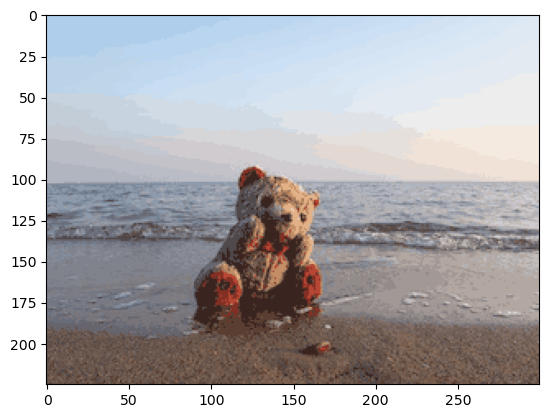

In [23]:
display_image(compress_image(load_rgb_image(IMAGE_FILE_PATH), 64, 25.5, random_state=2109))

Expected comparison between original and compressed image for your reference:

<table>
<tr align="center">
    <td><img src="images/teddy_bear.jpg" width="300"></td>
    <td><img src="images/compressed_image.png" width="300"></td>
</tr> 
</table>

# Part 2: Image Classification

In this section, we shall help Gnoel with the problem of recognising handwritten
digits.

**IMPORTANT**: Throughout this problem set, you may assume that each image is
monochrome (i.e. has only one channel, instead of 3 channels) and that each
image is 28*28 in size.

**Gentle reminder that there is penalty for using iterative method where numpy is possible. We have written down the number of loops needed in each of the task as a comment.**

## Background

A few months ago, Gnoel was appointed as the CEO of the postal service Iaiml, and weeks into the appointment, he realised how acute the manpower shortage is. To exacerbate matters, in recent years, Iaiml's profit margins have been narrowing, making the option of hiring more employees unviable. Observing this, Gnoel decides to automate certain processes.

One such process is the entry of postal codes into the system. Specifically, instead of hiring people to look at each envelope and keying in the postal code manually, he wants to develop a machine that is capable of capturing these postal codes and recognising each digit of the postal codes, so that they can be entered into the system automatically. 

He has managed to get an engineer to develop a machine that can automatically capture images of individual digits in handwritten postal codes. However, the task of automatically recognising handwritten digits is still incomplete, and upon learning that you are about to complete a course in artificial intelligence and machine learning, he has approached you to work on the latter task: the recognition of handwritten digits.

## About the Data

Leveraging on the aforementioned machine, Gnoel can create a dataset consisting of **many images of handwritten digits**. Unfortunately, due to the low profits Iaiml has been making, he has difficulty paying people to label them, resulting in a **much smaller dataset of labelled images**. The unlabelled data can be found in **digits_train.csv** and the lablled data can be found in **digits_validation.csv**(The data is in fact obtained from the MNIST dataset.). **You may assume that all images have dimensions $28 \times 28$.**

## Load Digits Data

The following lines of code load the required data. To be specific, `train_digits`
is a 2D matrix such that `train_digits[i].reshape((28, 28))` returns the monochrome image of the 
`i`th handwritten digit that is found in the training dataset. The same can be
said about `validation_digits`, with the difference that the handwritten digits
are obtained from the validation dataset. Lastly, `validation_labels` returns
the label of each handwritten digit that is in the validation dataset. In other
words, `validation_labels[i]` returns the true label for `validation_digits[i]`.
For example, if `validation_digits[i]` is the image of the number 9,
`validation_labels[i]` will be equal to 9.

In [18]:
train_data = load_digits_data_train()
validation_data = load_digits_data_validation()

train_digits = train_data
validation_digits = validation_data[0]
validation_labels = validation_data[1]

## Part 2.1: Classification Using K-Means Clustering

In this subsection, we shall attempt to classify (and hence recognise) the
handwritten digits using the K-Means clustering algorithm which we have 
implemented previously.

### Task 2.1.1: Mapping Clusters to Digit Labels

Now that we have the centroids, given any new sample $x_i$, we can easily predict which cluster it belongs to. However, this is not very helpful since Gnoel wants to know the **digits, not the cluster assignment**, of the postal codes. After all, there is not much that he could do, if he just knew that $x_i$ belongs to cluster 5, for example. Instead, he wants to know what digit $x_i$ represents. Therefore, we need to map each cluster to a digit, so that after finding that $x_i$ has a particular cluster assignment, we can tell Gnoel what digit it represents using this mapping. This is what we shall do in this question.

In this task, **you are to find `cluster_to_digit`** (a 1D NumPy array) such that
`cluster_to_digit[i]` indicates which digit the `i`th
cluster represents, **when the clusters are obtained using the given values**
for `n_clusters=10`, `threshold=2`, `n_init=5` and `random_state=2109` with the
K-Means algorithm. For instance, if sample points that
are assigned to the 5th cluster are meant to  be the digit 0, `cluster_to_digit[5]`
should return 0.

On Coursemology, in addition to stating the value of `cluster_to_digit`, **please also describe
how you found it**.

NOTE: you may find the helper function `display_image` helpful here.

In [19]:
_, centroids = k_means(train_digits, 10, 2, n_init=5, random_state=2109) # NOTE: do NOT modify this

print('Centroids:' + str(centroids))

Centroids:[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [33]:
cluster_to_digit = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # TODO: replace the '0's with the values that you have found

def convert_cluster_to_digit(cluster_to_digit, centroids):
    '''
    Converts the cluster centroids to digits.

    Parameters
    ----------
    cluster_to_digit: np.darray
        An array of length 10, where `cluster_to_digit[i]` is the digit that the
        `i`th cluster centroid represents.
    centroids: np.darray
        An `n_clusters * n` matrix where `n_clusters` is the number of clusters
        and `n` is the number of features which each sample has. In particular, 
        `centroids[j]` represents the `j`th cluster's centroid.

    Returns
    -------
    An array of length 10, where `digit_to_cluster[i]` is the cluster that the
    `i`th digit is represented by.
    '''
    # Assign each validation image to a cluster
    distances = np.sqrt(((validation_digits - centroids[:, np.newaxis])**2).sum(axis=2))
    validation_cluster_labels = np.argmin(distances, axis=0)
    # Determine the most frequent digit for each cluster
    for i in range(10):
        # Filter validation labels for each cluster
        labels_in_cluster = validation_labels[validation_cluster_labels == i]
        
        # Find the most common label
        cluster_to_digit[i] = np.bincount(labels_in_cluster).argmax()

    return cluster_to_digit

print('Cluster to digit:' + str(convert_cluster_to_digit(cluster_to_digit, centroids)))



Cluster to digit:[8 1 6 5 3 4 7 9 0 2]


### Task 2.1.2: Predicting Labels with K-Means

Your next task for part 2.1 is to implement `predict_labels_kmeans`.

Now, let us implement the function `predict_labels_kmeans` (which we will later use in task 2.2.7) to predict the *digit labels* of each digit image. 

This function accepts `centroids`, the centroids of the clusters found using K-Means clustering, `cluster_to_digit`, which maps each cluster to the digit it represents, and `digits`, which represents the images of digits whose digit labels are to be determined.

Then, it returns the predicted digit labels for each digit image in `digits`. Suppose the returned value is `pred_labels`, then `pred_labels` should be such that `pred_labels[i]` gives the predicted digit label for the $i$-th digit image in `digits`.

You can use functions implemented earlier.

In [34]:
def predict_labels_kmeans(centroids, cluster_to_digit, digits):
    '''
    Predicts the digit labels for each digit in `digits`.

    Parameters
    ----------
    centroids: np.darray
        The centroids of the clusters. Specifically, `centroids[j]` should represent
        the `j`th cluster's centroid.
    cluster_to_digit: np.darray
        A 1D array such that `cluster_to_digit[j]` indicates which digit the `j`th
        cluster represents. For example, if the 5th cluster represents the digit 0,
        then `cluster_to_digit[5]` should evaluate to 0.
    digits: np.darray
        An `m * n` matrix, where `m` is the number of handwritten digits and `n` is
        equal to 28*28. In particular, `digits[i]` represents the image
        of the `i`th handwritten digit that is in the data set.
  
    Returns
    -------
    A 1D np.darray `pred_labels` with `m` entries such that `pred_labels[i]`
    returns the predicted digit label for the image that is represented by
    `digits[i]`.
    '''
    # assign each digit to a cluster
    distances = np.sqrt(((digits - centroids[:, np.newaxis])**2).sum(axis=2))
    cluster_labels = np.argmin(distances, axis=0)
    # convert cluster labels to digit labels
    pred_labels = cluster_to_digit[cluster_labels]
    return pred_labels


In [35]:
# Public test case 1
test_centroids_212 = np.array([[ 0, 1], [100,101], [200,201], [300,301], [400,401]])
test_centroids_to_digits_212 = np.array([2,0,4,3,1])
test_digits_212 = np.array([[6.36961687e-01,2.69786714e-01], [4.09735239e-02,1.65276355e-02], [8.13270239e-01,9.12755577e-01], [6.06635776e-01,7.29496561e-01], [1.00543625e+02,1.00935072e+02], [1.00815854e+02,1.00002739e+02], [1.00857404e+02,1.00033586e+02], [1.00729655e+02,1.00175656e+02], [2.00863179e+02,2.00541461e+02], [2.00299712e+02,2.00422687e+02], [2.00028320e+02,2.00124283e+02], [2.00670624e+02,2.00647190e+02], [3.00615385e+02,3.00383678e+02], [3.00997210e+02,3.00980835e+02], [3.00685542e+02,3.00650459e+02], [3.00688447e+02,3.00388921e+02], [4.00135097e+02,4.00721488e+02], [4.00525354e+02,4.00310242e+02], [4.00485835e+02,4.00889488e+02], [4.00934044e+02,4.00357795e+02]])
expected_digits_212 = np.array([2,2,2,2,0,0,0,0,4,4,4,4,3,3,3,3,1,1,1,1])

assert np.all(predict_labels_kmeans(test_centroids_212, test_centroids_to_digits_212, test_digits_212) == expected_digits_212)

## Part 2.2: Exploring PCA for Optimisation

A couple of days later, your friend Ada hears about the project that you are working on, and has a cursory look at it. Looking at the data, she wonders whether your approach can be improved with the help of *dimensionality reduction* techniques. She urges you to try applying *principle component analysis* (PCA) on your data, **before** clustering is done. Intrigued, you decide to give it a shot.

##### **IMPORTANT**: In the rest of this problem set, we shall follow scikit-learn's convention where `X` is defined to be an $m \times n$ matrix such that `X[i]` returns the features for the $i$-th sample.

## (Informal Re-)Introduction to PCA
This subsection introduces the principles of PCA. If you are already familiar with PCA, you can skip this section and go to the next section.

##### Understanding Data as Signal and Noise
Before we can get into PCA, we need a common understanding of what *data* really comprises of. In particular, one way of viewing data is that it is composed of *noise* and *signal*. Here, *signal* simply refers to the 'true' underlying measurements, in the absence of *noise*. Now, it should be clear that a dataset that is of 'high quality' is one that has high signal but low noise. 

##### Importance of Feature Variation
Assuming we have a high-quality dataset, we expect the features that are critical for differentiating one class of objects from another to be significantly different. Therefore, the variation in these features among the different data points should be higher. In contrast, features that are less critical will tend to have no, or minimal variation that is caused by (the low level of) noise. 

As a result, it makes sense for us to ignore features having less variation, but retain features having higher variation. Not only will this help us to get rid of features that are unimportant or noisy, it will also simplify the data by reducing its dimension, in turn making processing more efficient.

##### Example: Dimension Reduction of Binary Images
To make things more concrete, let us consider a simple example. Suppose we have two binary images (i.e. images where each pixel is either 0 or 1, with 0 resulting in a black pixel and 1 resulting in a white pixel) as shown below. Moreover, to represent each binary we can represent each binary image as a 1D array of size 25, denoting each pixel.

<table>
<tr align="center">
    <td><img src="images/zero.png" width="300"></td>
    <td><img src="images/one.png" width="300"></td>
</tr>
</table>

It should be obvious that, in fact, the 16 pixels around the perimeter will not help us to differentiate the image '0' from the image '1', since they have the same values (0) in both images. In other words, we can ignore these features, and instead represent each image with a 1D array of size 9, where it represents the $3 \times 3$ in the center. Notice that this array has significantly fewer entries than the original one, i.e. the dimension of the data has been reduced, and we have effectively changed the coordinate system when changing the image's data representation. In general, this is what we hope to achieve: **reduce the dimension of the data while maintaining most of the variation in the data**.

##### Dimension Reduction with PCA
Unfortunately, in most real world scenarios, features that are deemed less relevant are not so obvious. In fact, this is exacerbated by the presence of noise and more complex data. Thus, we need a more sophisticated and systematic way to do dimensionality reduction. 

Specifically, *variance* is used to quantify the variation in the features of different data points, and results from linear algebra (more precisely, eigenvectors and SVD) are used to determine how the coordinate system should be changed such that the variance of the data points, as defined in this new coordinate system, is maximized. In essence, this is what PCA does.

For example, given data points with $D$ features, PCA will systematically transform these $D$ features into $N$ features (often, these new $N$ features are a combination of some features of the original dataset, before PCA is applied.), where $N \leq D$ and $N$ is a user-specified value, such that the variation of the transformed data along these $N$ axes is maximised.

### Task 2.2.1 Implementing PCA with SVD
Now that we have a high level idea understanding of how PCA works, why don't we have a closer look at it by trying to implement PCA with what we have seen during the lecture? 

Please implement `my_pca` which performs PCA as described in lecture 11. This function takes `X` and `n_components` as inputs. 

**IMPORTANT:** Here, **unlike what is shown in lecture**, `X[i]` represents the features of the $i$-th sample, and you **should center `X` before using it for any computations** (i.e. you should use `X`' in your computations, where `X`' is identical to `X` except that every feature of `X`' has a mean of 0). Besides these differences, your solution should be same as that shown in lectures.

You should use [`np.linalg.svd`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html) to do SVD. 

This function should return a tuple `(components, singular_values)`, where `components` is an `n_components` $\times$ `n` matrix such that `components[i]` returns the $i$-th principal axis (or component) that has the $i$-th largest singular value. In addition, `singular_values` is a 1D Numpy array with `n_components` entries such that `singular_values[i]` returns the $i$-th singular value.

**Hint:** Because of how the rows of `X` in this problem set are the columns of `X` in the lecture slides, you **MUST** consider the transpose of the matrices, wherever relevant. All other aspects of the computations, besides the aforementioned ones, should remain the same.

In [101]:
def my_pca(X, n_components):
    '''
    Performs PCA on X to reduce it to `n_components`, using the method
    described in lecture but with the 'centering' of X before SVD is done.

    Parameters
    ----------
    X: np.darray
        An `m * n` matrix where `m` is the number of samples and `n` is the
        number of features which each sample has. In other words, the `i`th sample
        is given by `X[i]`.
    n_components: int
        No. of components that the reduced space has.
  
    Returns
    -------
    The tuple `(components, singular_values)`. Here, `components` is an
    `n_components * n` matrix such that `components[i]` returns the `i`th
    principal axis that has the `i`th largest singular value. In addition,
    `singular_values` is a 1D numpy array with `n_components` entries such that
    `singular_values[i]` returns the `i`th singular value.

    Note
    ----
    'centering' here refers to subtracting the mean from X such that the resulting
    X' has a mean of 0 for each feature.
    '''
    # centering
    X = X - X.mean(axis=0)
    # compute covariance matrix
    cov = X.T @ X
    # compute SVD
    U, S, V = np.linalg.svd(cov / X.shape[0])
    # return first n_components principal components
    return V[:n_components, :], S[:n_components]


In [102]:
X_test_1 = np.array([[ 0.16550775,-16.57982642,-50.13603715,-20.68348877, 8.80989065], [ 27.74489674, 17.10507978, 18.71626655, 32.02624683, 20.99010911], [ 18.05469443,-43.28464778, 31.50703811,-18.97769479, 0.44841138], [-45.96509892, 42.75939443, -0.08726752, 7.63493673,-30.24841115]])
expected_pca = my_pca(X_test_1, 2)
# Public test case 1
assert(not np.all(expected_pca[1] == np.array([7282.76644566, 4817.22025846])))
# Public test case 2
assert(not np.all(expected_pca[1] == np.array([2427.58881522, 1605.74008615])))
# Public test case 3
diff_singular_values = np.abs(expected_pca[1] - np.array([1820.69161142, 1204.30506462]))
assert(np.all(diff_singular_values < 0.000001))

# Public test case 4
X_test_4 = np.array([[63.69616873,26.97867138, 4.09735239, 1.65276355,81.32702392], [91.27555773,60.66357758,72.9496561 ,54.36249915,93.50724238], [81.58535541, 0.27385002,85.74042766, 3.35855753,72.96554464], [17.56556206,86.31789223,54.14612202,29.97118905,42.26872212]])
diff_singular_values_4 = np.abs(my_pca(X_test_4, 2)[1] - np.array([1820.69161142,1204.30506462]))
assert(np.all(diff_singular_values_4 < 0.000001))

# Public test case 5
X_test_5 = np.array([[0.22733602,0.31675834,0.79736546,0.67625467,0.39110955,0.33281393, 0.59830875], [0.18673419,0.67275604,0.94180287,0.24824571,0.94888115,0.66723745, 0.09589794], [0.44183967,0.88647992,0.6974535 ,0.32647286,0.73392816,0.22013496, 0.08159457], [0.1598956 ,0.34010018,0.46519315,0.26642103,0.8157764 ,0.19329439, 0.12946908]])
diff_singular_values_5 = np.abs(my_pca(X_test_5, 3)[1] - np.array([0.14205335,0.06453807,0.0472502]))
assert(np.all(diff_singular_values_5 < 0.000001))

# Public test case 6
X_test_6 = np.array([[0.22733602,0.31675834,0.79736546,0.67625467,0.39110955,0.33281393, 0.59830875], [0.18673419,0.67275604,0.94180287,0.24824571,0.94888115,0.66723745, 0.09589794], [0.44183967,0.88647992,0.6974535 ,0.32647286,0.73392816,0.22013496, 0.08159457], [0.1598956 ,0.34010018,0.46519315,0.26642103,0.8157764 ,0.19329439, 0.12946908]])
diff_singular_values_6 = np.abs(my_pca(X_test_5, 3)[1] - np.array([0.14205335,0.06453807,0.0472502]))
assert(np.all(diff_singular_values_6 < 0.000001))

## Performing PCA with Scikit-Learn

Now that we know what PCA does in principle, let us have a look at how we can do it with the package Scikit-learn. The documentation for PCA can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA).

We have already imported PCA from Scikit-Learn in the beginning. The following sections will explain how we can use the package.

Firstly, we need to create a PCA model.
```pca = PCA(n_components=70)```. In this case, we have chosen N to be 70. 
Then, to find the 'right' coordinate system to which we want to transform the data, we need to do the following:

`pca.fit(X) # where X is the dataset`

Now, whenever we have some data `A`, where each column of `A` represents the same feature as that of `X`, we can transform it simply by making the following call:

`A_transformed = pca.transform(A)`

After being transformed, `A_transformed[i]` will have $N$ (transformed) features, where $N = 70$ because we have previously chosen $N$ to be 70. 

Recall that the transformation is done such that in the new coordinate system, most of the variation in `X` (before transformation) will be retained. Therefore, if each column of `A` and `X` represent the same feature(In fact, more importantly, we need `A` and `X` to be samples that are drawn from the same population.), we expect that most of the variation in `A` to be retained after transformation as well.

Besides these, you might find `pca.explained_variance_ratio_` insightful. In particular, it returns an array of length $N$ such that the $i$-th entry indicates, out of the total variance in the data, how much of it is contributed by `X` along the $i$-th transformed axis. Note that the axes have been chosen such that an axis, along which there is more variation, is placed towards the left. Therefore, the values in `pca.explained_variance_ratio_` is non-increasing, similar to what we have seen in lecture 11. To put it differently, in the transformed coordinate system, axes that are more important come before those that are less important.

Lastly, you may need `pca.inverse_transform(A_transformed)` for this problem set as well. This function works as follows. Suppose the output from this function is `A`'. Then, `A`' is an approximation of `A`(It will be exact, however, if we choose $N = D$, where $D$ is the number of axes in the original coordinate system). As such, if $N$ is chosen appropriately, we will expect `A`' and `A` to be close; however, if $N$ is chosen to be too small a value, `A`' might not represent `A` well since when transforming `A` to `A_transformed`, a significant amount of signal from `A` has been lost in the smaller coordinate system. 

For a concrete example, we recommend you to run the below code with different values of $N$.

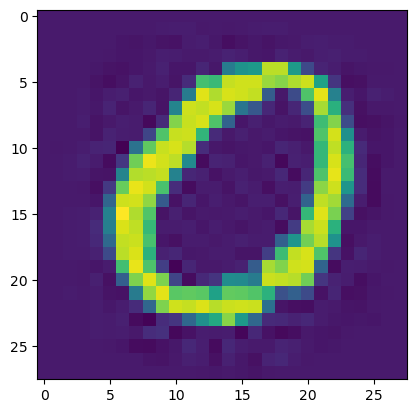

In [110]:
N = 300
pca = PCA(n_components=N, random_state=2109)
pca.fit(train_digits)
transformed_digits = pca.transform(train_digits[1:2])
approximated_digits = pca.inverse_transform(transformed_digits)
display_image(approximated_digits[0].reshape((28, 28)))

### Task 2.2.2 (Bonus): Comparing `my_pca` with scikit-learn's `PCA`

Run the following code. What is it about scikit-learn's implementation that
could have caused this discrepancy? **State the reason on Coursemology.**

In [111]:
_, singular_values_my_pca = my_pca(train_digits, 5)
sklearn_pca = PCA(n_components=5, svd_solver='full')
sklearn_pca.fit(train_digits)
singular_values_sklearn = sklearn_pca.singular_values_


print('Singular values obtained with my_pca: {}'.format(singular_values_my_pca))
print('Singular values obtained with scikit-learn\'s PCA: {}'.format(singular_values_sklearn))

Singular values obtained with my_pca: [314493.08690992 237228.3638359  189209.97079049 165966.06636625
 157812.16391951]
Singular values obtained with scikit-learn's PCA: [30199.83364257 26229.03458239 23424.53660785 21938.58683831
 21392.87908082]


In [ ]:
# TODO: you **may** want to write some code here to find the relationship between the two

You may want to type your solution here before copying it to Coursemology.

[TODO, double click on the cell to access markdown]

### Task 2.2.3: Finding Number of Components
Run the following code and find the least number of components needed to
obtain an explained variance of at least 99%. State your answer on Coursemology.

In [112]:
full_pca = PCA(svd_solver='full')
full_pca.fit(train_digits)

PCA(svd_solver='full')

In [116]:
# find the least number of components needed to explain 99% of the variance
cumulative_variance = np.cumsum(full_pca.explained_variance_ratio_)
print('Cumulative variance: {}'.format(cumulative_variance))
n_components = np.argmax(cumulative_variance >= 0.99) + 1
print('No. of components needed to explain 99% of the variance: {}'.format(n_components))

Cumulative variance: [0.09683644 0.16988209 0.22814226 0.27924533 0.32783772 0.36838967
 0.40073183 0.42812961 0.45500298 0.47723278 0.49921809 0.52006882
 0.53711566 0.55408086 0.5699315  0.58445745 0.59813612 0.61154512
 0.62396115 0.63562169 0.64670283 0.65746173 0.66698713 0.67643019
 0.68560479 0.69455619 0.7027217  0.71035398 0.71787372 0.72496212
 0.73196026 0.73869461 0.74523559 0.7516991  0.75761421 0.76332853
 0.76859972 0.77368383 0.77872304 0.78365107 0.7883124  0.79278466
 0.79719086 0.80143727 0.80547368 0.80936935 0.81317916 0.81676148
 0.82027557 0.82376574 0.82706188 0.83026749 0.83340211 0.83646508
 0.83943438 0.84226537 0.8450083  0.84766942 0.85028074 0.85286728
 0.85540662 0.85785719 0.86029598 0.86266027 0.86495601 0.86718631
 0.86935832 0.87147089 0.87351823 0.87552774 0.87747134 0.87939838
 0.88130547 0.88318717 0.884953   0.88666163 0.8883322  0.88997246
 0.8915366  0.89306678 0.89457148 0.89602197 0.89744999 0.89886122
 0.90025237 0.90159131 0.90292244 0.90424

### Task 2.2.4: Find K-Means Clusters with PCA

Now that we are clear about how PCA works, let us try to perform K-Means clustering again. However, this time, we shall first reduce the dimensionality of our data using PCA, then do clustering. Please implement your solution in `find_kmeans_clusters_w_pca`. 

**IMPORTANT: From this task onwards, you should use scikit-learn's `PCA`**.

The inputs which `find_kmeans_clusters_w_pca` takes are almost identical to those of `k_means`. The only difference is that `find_kmeans_clusters_w_pca` accepts an additional argument `n_components` which specifies $N$ for the PCA model.

Here, the output should be `centroids` **and** `pca`, where `centroids` is an `n_categories` $\times$ `n_components` matrix representing the centroids of the clusters in the transformed coordinate system (or space), and `pca` is the PCA model that is used to perform this transformation.

**IMPORTANT**: please call `PCA` with `random_state` set to `find_kmeans_clusters_w_pca`'s `random_state` input value, and other than this argument and `n_components`, use the default values for the other arguments.

In [ ]:
def find_kmeans_clusters_w_pca(digits, n_categories, threshold=2,\
    n_init=5, random_state=2109, n_components=70):
    '''
    Finds the centroids of the `n_categories` clusters given `digits` when PCA
    is used to reduce the dimensionality of each image.
    
    Parameters
    ----------
    digits: np.darray
        An `m * n` matrix, where `m` is the number of handwritten digits and `n` is
        equal to 28*28. In particular, `digits[i]` represents the image of the `i`th
        handwritten digit.
    n_categories: int
        The number of distinct digits.
    threshold: double
        Threshold that determines when the K-means algorithm should terminate. This
        should be used with `k_means`.
    n_init: int
        The number of times to run the K-means algorithm before picking the best
        cluster. This should be used with `k_means`.
    random_state: int or `None`
        Used to make the K-means and PCA deterministic, if specified.
    n_components: int
        The dimension to which each sample point is reduced, using PCA.

    Returns
    -------
    An `n_categories * n_components` matrix `centroids`, where `centroids[j]` is 
    the centroid of the `j`th cluster, AND the PCA model that is used to reduce
    the dimension of each image.
    '''
    # TODO: add your solution here and remove `raise NotImplementedError`
    # no loop allowed
    raise NotImplementedError

In [ ]:
# RUN THIS BEFORE RUNNING THE TEST CASES
expected_centroids_w_pca_224_1 = np.array([[ 4.41146747e+01,-3.97240692e+02, 5.10363670e+02,-2.94303812e+02, 1.90506902e+02, 3.19233952e+02,-4.04259213e+01, 4.93623367e+01, 1.17871222e+02,-3.86770830e+01,-9.76516902e+01,-1.10009417e+02, 8.75107032e+01, 3.95818261e+01,-1.76351356e+01,-6.05964921e+01, 1.03819916e+01,-1.25288033e+01,-2.43332562e+01,-1.65128997e+01, 5.17947320e+01, 2.04253628e+01,-3.64743512e+01,-1.08179498e-01, -3.62848940e+01, 3.95743508e+01,-2.76116198e+01, 1.25942325e+01, -3.09429039e+00,-6.46023523e+00,-1.42836685e+01,-1.59739468e+01, 1.96926009e+01, 4.48563092e+01,-2.02701257e+01, 4.91357703e+00, -5.62752563e+00,-1.19638851e+01,-2.68788441e-01, 2.49324434e+01, 1.25017490e+01, 8.93853870e+00,-8.25232052e+00, 3.31333914e-01, 6.97279189e+00,-6.29506935e+00, 3.42502194e+00, 2.76428108e+00, -9.26678271e+00,-1.26575625e+01, 3.24180853e+00,-1.17955053e+00, 1.40314375e-01,-1.56325905e-01, 1.86431042e+01, 9.49833455e+00, -4.37827561e+00, 9.69451007e+00,-2.45278573e+00,-1.40077762e+00, 3.46570617e-01,-4.85198866e-01, 1.25337573e+01, 1.93045344e+01, -5.07672424e+00, 1.28042647e+01,-1.05606510e+01, 7.13735274e+00, 3.85926281e+00, 2.66909049e+01], [ 3.43440646e+01,-1.23091183e+02, 1.07548194e+02,-7.52886984e+01, 7.26752358e+02,-1.82032031e+02, 4.36975586e+00,-2.03166773e+02, -1.83916710e+02, 1.74386500e+02,-4.72295635e+01, 3.51534865e+01, -1.47698829e+02,-1.75684242e+02, 9.42299448e+00,-8.00366704e+01, -4.56711498e+00, 1.30015040e+01,-9.56510388e+00,-1.84441031e+01, 2.73027865e+01, 5.13061191e+01, 1.71553294e+01, 1.10864802e+01, -2.58300107e+01,-1.47613401e+00, 5.62178397e+01,-1.15063340e+01, 4.22323402e+01, 1.86188465e+01, 1.84888723e+01,-1.20641515e+00, -6.70484759e+00, 2.54654573e+01,-2.39838440e+01,-6.00847360e+01, 2.96562151e+01, 2.60653689e+00, 1.31855395e+00,-4.31632588e+01, 1.39164063e+01,-3.44061968e+01,-6.51564742e+00, 1.19979383e+01, 8.48439346e+00, 1.77203872e+00,-1.68226999e+01, 1.22910593e+01, -8.96544753e+00,-1.12132900e+01,-1.43635179e+00, 1.92704604e+01, 1.56780309e+01,-7.01840642e+00, 1.44422724e+01,-6.72455336e+00, -6.70754344e+00, 3.63491824e+00,-1.16563011e+01,-1.33303015e+01, 1.55998897e+01,-5.20495273e-01, 2.92315368e+00, 2.61663260e+01, -1.47052507e+00,-1.52076924e+01,-7.34671156e+00, 9.36539774e-01, -3.98343537e+00,-2.31594779e+01], 
[ 5.42512573e+02, 3.72441475e+02,-5.42300990e+02,-4.37470793e+02, -2.72885981e+02, 2.29801621e+02, 1.86715048e+02,-3.35192475e+01, -1.53562958e+02,-8.24332212e+01,-1.46676354e+02, 1.37485622e+02, 1.00007452e+02,-1.03944628e+02, 1.81981294e+01,-7.55301266e+01, -4.56164408e+01,-1.13126594e+02, 1.58593583e+02, 3.62892761e+00, 6.46159255e+01, 1.60160772e+01,-6.10785110e+01,-3.68514908e+01, -4.09507334e+01,-7.13715084e+01, 2.49666025e+01, 6.22057886e+01, 8.40325155e+01,-9.11768731e+00, 5.41995913e+00,-2.54173413e+00, -5.48196676e+01,-1.14936162e+01, 8.77622332e+00, 5.99599689e+00, 4.24541079e+01, 1.65025881e+01,-6.03472660e+01,-1.91215237e+01, 6.29597657e+00, 1.83801823e+01, 6.24994505e+00,-4.53187131e+01, -7.25410775e-01,-1.02947851e+01,-1.52242904e+01, 4.39179900e+00, 2.42872818e+01,-8.44650772e+00,-6.79063161e+00,-6.53665958e+00, 2.97647613e+00, 1.00251441e+01, 8.24597697e+00, 1.34548288e+01, 1.88195934e+01, 5.37531602e+00,-2.53018410e+00,-3.60797348e+00, 1.68866494e+01, 2.77009222e+00,-4.05828060e+00,-2.40365094e+01, 3.87731066e+00, 1.28769951e+01, 9.61629098e+00,-4.82477813e+00, -2.31731920e+01, 2.96323009e+01], [ 4.18430104e+02,-1.51347320e+02,-3.96564119e+02, 4.95129949e+02, 3.57119464e+01, 2.63481338e+02, 8.45772420e+01,-1.77284086e+02, 1.76166438e+02, 3.58547555e+01, 1.60395162e+02,-1.47683964e+02, -4.53100507e+01, 1.80592390e+01, 6.36212214e+00, 1.55955789e+01, -6.75646020e-01, 2.26235729e+01, 2.61805223e+01, 5.60129817e+01, 3.41668886e+01, 8.61248484e+00, 5.64006070e+01, 5.66359634e-02, 6.93045971e+01,-8.83478890e-01, 2.41318451e+01,-2.05315258e+01, -8.10876502e+00,-1.90097200e+01,-1.04925202e+01, 2.53856513e+01, 3.21287592e+01, 1.71577899e+01, 5.26021624e+00, 2.50365208e+01, -3.34141175e+01,-2.30566909e+01, 2.21844695e+01, 5.55631439e+01, 7.32181865e+00,-9.12010599e+00,-4.63559342e+00, 5.65810950e+00, 1.29628560e+01,-1.30115996e+01,-1.62649620e+01, 1.66616602e+01, -1.86278670e+01, 2.90698932e+00,-2.15473198e+01, 5.27303030e-01, 2.29989100e+01, 8.13134030e+00,-1.76255044e+01, 9.90687911e-01, 1.05291344e+01, 3.35019674e+00, 4.95391366e-01,-6.71659182e+00, 3.24891021e-01, 7.19777825e+00, 6.36114037e+00,-4.71738998e+00, -1.39844441e+01, 7.48267642e+00, 4.63335862e-01,-9.34191816e-03, 4.95674704e+00, 5.30044998e+00], 
[ 1.12060551e+03,-1.36455661e+02, 4.44410760e+02,-1.70241314e+02, -3.75131886e+02,-2.44150073e+02, 1.76851461e+02,-8.27106514e+01, -1.54885659e+02,-7.17487515e+01, 8.59043925e+01, 8.73480630e+01, -5.24321813e+01, 1.00821971e+02, 2.07178482e+01, 4.37883293e+01, -1.12555778e+01, 5.88723098e+01,-8.62615752e+01,-8.37865871e+01, 1.79239348e+00, 3.54663483e+01, 3.05466808e+01, 3.57940326e+01, -4.89710854e+01, 6.58341271e+00,-4.86565692e-01,-3.24191990e+00, -3.44458898e+01, 6.61211842e+01,-4.69206169e+01,-2.63336958e+00, -2.13619140e+01,-4.99876853e+00, 1.08550700e+01, 1.03023122e+01, -1.76050641e+01,-2.11583816e+00, 3.75151251e+00,-1.66131028e+01, -2.44756684e+01,-3.75950280e+01, 1.13151909e+01, 2.10212080e+01, -1.63486464e+00,-2.93302748e+01, 1.21143034e+01,-2.41916273e+01, -1.42779557e+01, 2.39087355e+01, 4.35593256e+00,-3.79762649e+00, 1.26145973e+01,-2.82011849e+00, 1.76942385e+00,-9.77977014e+00, -9.62960284e+00,-1.31339799e+01, 1.24216326e+01, 1.04378407e+01, -1.38599878e+01, 2.49941068e+00,-7.90344061e+00, 1.73379627e+00, 2.17118294e+00,-4.18417877e+00, 1.86069586e+00,-4.24971310e+00, 2.19383586e+00,-1.72411423e+01], [-5.52535379e+01, 7.71965382e+02, 2.74104510e+01,-5.08908195e+00, 4.45893126e+01, 1.23319481e+02,-1.93089947e+02, 1.90492740e+02, 5.90320783e+01, 7.25606552e+01, 1.77159809e+01, 5.34649940e+01, -6.11711367e+01,-1.24044604e+01,-1.17744149e+01, 4.80718098e+01, -2.16122349e+01, 4.38216453e+01,-2.52624424e+01,-3.09068820e+01, -4.38387586e+01,-4.33357271e+01, 4.36241106e+01, 1.53499949e+01, -6.20469389e+00,-1.73483781e+00,-1.30571320e+01,-2.05304354e+01, -1.42329848e+01, 1.84480050e+01,-7.47640730e+00,-5.37361629e+00, 8.68450171e+00,-1.46462878e+01,-9.08625575e+00, 4.06766131e+00, -9.16679885e+00,-2.23068975e+00, 2.23343345e+00,-1.91224106e+01, -9.99488113e-01, 2.63105032e-01, 1.25432469e+01,-1.71861872e+00, -4.42326801e+00, 7.76926701e+00, 5.09126773e+00,-7.87003989e+00, 1.55707253e+00, 7.78635459e+00, 1.03502798e+01,-1.26310532e+00, -1.07387279e+00, 3.71581261e+00, 1.73787850e+00,-7.29575536e+00, 1.77893598e+00,-3.35477780e+00, 3.49765786e+00,-5.15289373e+00, -1.57630012e+01,-3.57840162e+00, 3.37421856e+00, 9.83777675e+00, -2.64231635e-01,-5.00400438e+00,-2.13908607e+00,-7.60240826e+00, 1.54003577e+00, 3.51617436e+00], [-5.45162066e+02, 4.03270879e+02, 6.06715970e-01, 1.51002925e+01, -5.07101624e+00,-3.14931468e+02, 1.34523793e+02,-1.77249314e+02, 8.96942889e+01,-2.42290292e+02, 1.33820981e+01,-1.08498357e+02, 1.00201308e+02, 1.08238002e+02,-5.69276090e+01,-1.29971347e+01, 6.71165749e+01,-4.67314218e+01,-3.88712306e+01, 4.60451475e+01, 6.77422676e+01, 7.61568044e+01,-3.36045770e+01, 2.28799130e+01, 4.32710880e+00,-2.94145237e+01,-3.80186969e+01, 1.38689582e+01, 4.22122478e+01, 1.82129713e+01,-2.35299154e+00, 1.14465743e+00, 1.55265606e+01, 3.22832540e+01, 2.56550533e+01,-8.69683472e+00, 9.93581807e+00, 2.63967435e+01, 1.46618134e+01, 1.29237755e+01, -1.20810232e+01, 1.23572494e+01,-8.54180532e+00, 1.76449060e+01, -6.36135619e+00, 2.92914076e+00, 4.34712848e+00,-2.06274381e+01, -2.33058512e+00, 1.41976981e+01,-1.40930133e+01,-4.14580970e+00, -8.23741132e+00,-2.71413534e+01,-1.13063841e+01, 6.71210824e+00, -3.44426192e+00,-1.07483990e+01, 4.60755911e+00, 1.03133662e+01, 2.21741658e+01, 5.81958885e+00, 6.36446606e+00,-9.58019774e+00, -6.67146225e+00,-7.92120607e+00,-4.52565882e-01, 2.48692454e+00, 7.00065888e+00,-5.47138954e+00], 
[-6.45364553e+02,-3.38497486e+02,-1.19768064e+02,-2.76081711e+01, -2.72834450e+02, 7.16131031e+00, 1.31400901e+02, 4.02015371e+01, -1.92550905e+02, 1.19835617e+02, 2.51517205e+01, 7.45402302e+00, -4.35252866e+01,-4.99053071e+01,-5.10791627e+01,-3.18619761e+01, -5.36879445e+01, 4.91162949e+01, 4.23916491e-01,-8.74257624e+00, -2.04169627e+01,-2.61624382e+01, 1.96496614e+01, 6.04963167e+00, -5.35390017e+00, 9.49318251e+00, 1.08670768e+01, 4.87414136e+00, -4.89402461e+01,-1.46108382e+01,-8.67694875e+00, 1.97538878e+01, -2.26404177e+01, 4.09794519e+00,-1.30764156e+01, 1.24382142e+01, 7.98561827e+00, 3.46465074e+00, 1.27997552e+01,-4.87496162e+00, 6.41016347e+00,-1.04062743e+01, 1.92956145e+00,-8.23571428e+00, -6.11806436e-02, 3.47119078e+00, 4.27388240e+00, 8.76670160e+00, 1.18360498e+01,-1.37051722e+01, 1.33112873e+01,-1.92944334e+01, 3.17165899e-01, 5.21790084e+00,-1.64927989e+00,-2.17068561e+00, 5.90546312e+00, 1.06862233e+01, 1.36063023e+01, 1.06981752e+01, -5.79931097e+00,-1.40877429e+00, 2.50774011e+00,-1.49355688e-02, 4.44072835e+00,-1.04471397e+01,-2.38780677e-01,-3.44774438e+00, 2.98751327e+00,-2.66429625e+00], [ 1.06422031e+02,-5.64896355e+02,-5.12447063e+02,-3.13063449e+02, 1.75046324e+02,-3.16619684e+02,-3.58609170e+02, 1.01262787e+02, 1.38283966e+02,-3.39390631e+01, 1.19905806e+01, 2.38305815e+01, -6.18608786e+01, 4.48008535e+01, 7.46826115e+01, 8.40711068e+01, 3.05078110e+01,-3.77220193e+01,-5.15560875e+01, 5.44343873e+00, -1.04892299e+02,-4.75447320e+01,-2.94984003e+01,-4.05145593e+01, 4.20428521e+01, 2.33063286e+01,-5.31443550e+01, 2.78089346e+01, -2.69984185e+01,-3.58682522e+01, 7.10119883e+01,-1.11766248e+00, 1.56755099e+01,-4.70852490e+01, 4.75171397e+00,-1.98030687e+01, -2.59404353e+01,-6.12271258e+00,-4.89949549e+00, 6.54106154e+00, -8.99944501e+00, 1.61529354e+01,-2.47137300e+01, 2.89591576e+01, -1.74563972e+01, 1.38589359e+01, 7.44935550e+00, 1.08601723e+01, 3.49782615e+01,-5.69632133e+00,-5.15360633e+00, 4.69749172e+00, -4.46562617e+01, 1.31605354e+01, 4.85031956e-01,-7.12623655e+00, 4.31888389e+00,-1.75006696e+01,-2.47676077e+00, 3.87669529e+00, -1.12151449e+01, 6.62372114e+00,-2.06358428e+01,-1.99299771e+01, 1.71748148e+01, 3.62355853e+00,-2.79567223e-01, 6.45987528e+00, -2.99107924e+00,-1.19641639e+01], [ 1.19074635e+01,-2.43454003e+02, 3.55970817e+02, 5.75802412e+02, -7.44983668e+01,-6.89205998e+01,-4.35919215e+01, 9.28077942e+01, 1.87988860e+00,-3.28456999e+00,-9.60548121e+01, 1.16867124e+02, 1.31849423e+02,-2.06119510e+01, 9.19474493e+01, 3.86233578e+01, 4.77644846e+01,-5.83683976e+01, 1.04625836e+02, 3.99118964e+01, -4.45226445e+01,-4.09858315e+01,-5.64607207e+01,-4.18741894e+01, 2.79648900e+01, 1.12700271e+00, 4.83678585e+01,-3.52296649e+01, 3.09760086e+01,-2.95721182e+01, 1.76872410e+01,-2.79859432e+01, -1.17860436e+01,-5.87864073e+01, 2.25648750e+01,-3.07943628e+00, 2.06323140e+01,-1.17400689e+00,-2.73069594e+01,-1.43592350e+01, -4.02953240e+00, 2.76952318e+01, 1.28357472e+01,-3.11077566e+01, 4.11173180e+00, 1.45354567e+01,-1.65581596e+00, 1.36317524e+00, -1.66775559e+01, 2.98608229e+00, 3.34336530e+00, 2.98150001e+01, 1.82567576e+00,-8.55034971e-01,-6.23455461e+00, 5.27499314e+00, -1.88687544e+01, 5.34495534e+00,-2.95999039e+01,-1.20385632e+01, 7.29039546e+00,-1.47986691e+01,-1.54767095e+01,-9.91021339e+00, 4.83639937e+00, 1.50155518e+01, 1.42761462e+01, 7.88473662e+00, -7.48990170e+00,-1.20567202e+01]])

expected_centroids_w_pca_224_2 = np.array([[-1.26388565e+02,-2.97805287e+02,-2.58743997e+02, 1.00615071e+02, 5.02583335e+02, 3.28468793e+02,-1.97043507e+02,-1.52104865e+02, -5.64894637e+01,-6.50940115e+01,-7.84923220e+01, 8.08940693e+01, 8.30301290e+01,-6.10133258e+00, 5.62609498e+00, 2.98112921e+01, 5.79705249e+01,-3.23610418e+01,-6.18559790e+01, 3.03730839e-01, -1.86899661e+01, 1.82035617e+01, 3.12677467e+01, 3.56583600e+01, 4.19771050e+01,-1.85904780e+01,-2.53463565e+01,-1.05794033e+01, -1.33036091e+01, 2.01308022e+01,-3.78505397e+01,-1.77072969e+01, -4.71928792e+01, 6.48880912e+00,-1.46476746e+01, 2.94119449e+01, -2.25368783e+01, 3.45956284e+01,-1.77294999e+01, 1.10087990e+01, 7.65872139e+00, 2.75045313e-01,-2.71896086e+00, 3.29257643e+01, -3.89132685e+00,-6.77181749e+00, 1.49421267e+00, 1.91614813e+01, -3.21099709e+00,-1.90989527e+01,-2.09268969e+00, 2.05412972e-01, -1.08773947e+01, 4.23956700e+00, 5.86144814e+00,-1.26752766e+01, -9.02383537e+00, 2.97634207e+00,-1.57723947e+01,-1.52569799e+01, -9.56215421e+00, 3.14401800e+00,-5.98361137e-01,-1.31087420e+01, -3.89557120e+00,-2.65180031e+00,-5.95495391e-01,-1.70958031e+01, 2.51495818e+00,-7.94813542e-01], [-4.27127711e+02, 1.02112004e+02,-1.55652325e+02, 1.93190981e+02, -2.83949541e+02, 3.44295520e+02, 8.51281189e+01,-1.80725999e+02, 4.47518188e+01, 2.48792779e+02, 1.43692247e+02, 2.96391432e+01, -3.37104349e+01, 1.09416598e+02,-5.94294589e+01,-4.18754981e+01, -2.35625110e+01, 5.65065601e+01, 2.04049206e+01, 3.16945974e+01, -5.71732561e+01, 6.26170201e+00,-1.30573458e+01, 2.68043449e+00, 6.40841440e-01,-6.89966768e-01, 7.18935871e+01,-2.82163385e+01, -6.35679482e+00,-1.33744524e+01,-2.87496949e+01, 2.07935311e+00, 5.34529825e+01,-2.56800761e+01, 2.92083638e+01, 8.81333815e+00, 5.87736029e-01,-1.90430028e+01, 7.97475361e+00,-8.01118257e+00, 1.97691695e+01, 6.07898032e+00, 1.52161491e+01,-2.46436129e+01, 6.00204131e+00,-1.29307947e+00,-3.01700519e+00, 1.33351673e+01, 1.27192394e+00,-2.01935980e+00,-2.22903861e+00,-1.12494427e+01, 5.20021300e+00,-1.76564360e+01, 1.51603827e+00,-4.68291645e-01, 8.96443912e+00,-2.41755371e+00, 1.49192165e+01,-8.97123612e+00, -2.16930602e-01, 4.64353232e+00,-2.98663400e+00, 9.49778486e+00, -1.89359394e+01, 8.66311571e+00, 1.67220618e-01, 1.36275486e+01, -5.48040192e+00,-6.33633372e+00], 
[ 7.30342241e+00,-3.65815706e+01, 7.71343648e+02, 1.19995251e+02, 2.52115792e+02, 2.09521800e+02,-5.41087703e+01, 4.25014533e+01, 1.20264938e+01,-1.49105376e+01,-9.54135315e+01,-2.02442276e+02, -5.75183700e+01, 4.96059254e+01, 5.29069159e+01, 1.08046060e+01, -7.43889273e+01, 5.46290908e+01, 9.15506130e+01,-2.41728913e+01, 3.77485306e+01,-6.47768124e+01, 3.43599647e+01,-1.75240369e+01, 4.11793238e+01,-2.58860442e+01, 2.50056855e+01, 6.06019998e+01, 5.46670704e+00,-5.60167792e+00, 1.49167495e+01,-5.58110256e+01, -1.76963563e-01, 5.70668693e+00, 4.82397188e+00,-1.84367370e+01, -2.40983652e-01, 1.44345176e+01,-5.06131757e+00,-3.11427765e+01, -9.92773176e+00, 2.86438312e+01,-1.44776983e+00, 1.84709312e+01, -1.26449944e+01, 1.39275803e+01,-3.41715401e+01,-7.27993319e+00, 1.72786868e+00, 5.15367110e+00, 1.95172609e+01,-1.32312629e+00, -1.47806734e+01, 1.28764763e+01,-1.50327360e+01, 1.06917986e+01, 7.10508768e-02, 1.32964932e+00, 6.76354662e+00, 1.75769812e+01, 3.16377725e+00, 1.29947054e+01,-3.00768287e+00, 2.38532344e-01, 1.46436202e+01,-2.67031436e-01, 3.92186734e+00,-9.61135382e+00, -2.07674276e+00, 2.15972506e+01], [ 8.87055326e+02,-4.73953190e+02,-2.54585667e+02, 6.01935830e+01, -3.48562790e+02, 4.16890508e+01, 4.92896433e+01, 2.29121937e+01, -5.18938683e+01,-1.03170742e+01,-1.16811216e+02, 1.50231640e+00, 2.93788756e+01,-5.30804431e+01,-6.19988477e+01, 6.69682724e+01, -4.56218002e+01, 1.56257007e+01, 5.90474183e+01,-1.47563014e+01, 4.77898559e+01,-3.88452335e+00,-2.33285246e+01,-2.25245752e+01, 2.03699393e+01, 2.85623812e+01,-3.15848415e+01,-2.51899693e-01, -3.59985424e+00,-2.48509077e+01,-4.12058553e+00, 1.67990293e+01, 3.82887966e+01, 2.56993471e+00,-1.10366191e+00,-4.63537857e+00, 5.49538107e+00, 1.08566108e+01, 1.67585158e+01, 3.40525903e+00, 7.74803196e+00, 6.80137534e+00, 1.63525233e+00,-6.00814154e+00, 1.15567997e+01,-2.44926871e+01,-1.23929628e+01, 2.63593247e+00, 5.11825597e+00, 7.56695233e+00,-3.23694567e+00,-1.12203495e+01, -1.32480515e+01,-1.00578885e+01,-7.42366384e+00, 1.49354274e+00, 1.28891916e+00, 3.38331782e+00,-6.31592338e+00,-2.10950090e+00, 8.96593127e+00,-1.64190946e+00,-6.15841147e+00, 5.59989196e-01, 4.02321104e+00,-3.84044857e-01, 1.80999072e-01,-1.37985385e+00, -3.59647873e+00,-4.73164060e+00], 
[ 1.14878099e+02,-4.07198554e+02, 4.61796715e+02,-2.97223374e+02, -7.56619365e+00,-2.73304315e+02,-3.90025713e+01,-1.30803032e+02, -5.80394935e+01, 6.81767516e+01, 1.65526170e+02, 6.41234339e+01, -1.22749575e+01, 1.98967425e+01, 1.26353175e+01,-6.56754638e+01, 5.57208275e+01,-5.90685517e+01,-1.92238999e+01, 3.22419918e+01, -1.17113813e+01,-1.69949990e+01,-8.38756648e+00,-2.23753469e+00, -5.01484485e+01,-1.44251213e+01,-1.09130684e+01,-6.17259649e+00, 9.07230007e+00, 9.72050792e+00, 1.50627573e+01, 2.07155795e+01, -1.05532046e+01,-3.74508975e+00, 7.86780764e+00, 8.30350039e+00, -2.00550343e+01,-2.21286476e+01, 2.34028712e+00, 1.10469562e+01, -1.47375107e+01,-1.50497263e+01,-3.60418058e+00,-2.42002993e+00, -7.12710353e+00, 2.34342561e+01, 2.19286197e+01,-3.97570225e+00, -1.18353991e+01, 2.06350734e+01,-1.51887607e+01, 1.90050383e+01, 2.07672477e+01, 1.40153388e+01, 1.18544203e+01,-4.86768979e+00, 3.59160338e+00,-3.39675716e-01, 1.16604565e+01, 5.95547853e+00, -8.77526236e+00,-5.77276955e+00, 8.76950061e-01,-4.30492882e+00, -6.73568495e+00, 2.78415612e+00,-3.67409060e+00, 4.43330844e+00, 2.72411445e+00,-1.23609285e+01], [ 5.07964327e+01, 8.03847983e+02, 1.47970519e+02,-1.47574678e+02, -1.01787935e+02,-1.79848745e+02, 3.92763180e+01,-1.35019174e+02, -1.10137429e+02,-5.40912837e+01,-2.44985268e+02, 7.96534556e+00, 3.73218410e+01,-3.43040759e+01, 4.29686859e+01,-6.21636402e+01, 4.54911984e+01,-9.66315586e+01,-1.33631653e+01,-3.09297902e+00, 2.87907991e+01, 1.02710992e+02,-3.87210092e+00, 2.77750136e+00, -1.47482865e+01, 2.80063172e+01, 1.99914501e+01,-2.19591997e+01, 1.61525006e+01,-4.65915129e+00,-7.63458394e+00, 1.19997622e+01, -2.12722032e+00, 1.31113471e+01,-4.19335372e+00, 9.73158790e+00, 1.50172011e+01, 9.66324044e+00,-5.39076801e-01, 1.69845573e+01, 2.11338949e+01,-4.70998720e+01, 4.15485530e+01,-1.88128967e+00, 2.23149372e+01,-4.39298919e+00,-3.81536212e+00,-9.50214895e-01, 1.47295947e+01,-2.33507586e+01, 2.61344567e-01,-5.56920015e-01, -8.28569886e+00,-1.67097226e+01, 2.35812539e-01, 1.50111136e+01, -1.28047019e+01,-1.04092896e+01,-1.17495432e+01, 1.45667479e+00, -1.02381521e+01,-9.40006987e+00, 8.60128653e+00,-1.60734852e+01, -8.42021639e+00,-7.12568476e+00, 3.80456970e-02, 2.19313844e+01, 1.01802420e+01, 1.44614274e+01], 
[-9.12756417e+02,-3.38137127e+02,-2.63820701e+02,-1.99539738e+02, -1.26082528e+02,-9.58456251e+01, 1.04748777e+02, 2.34488061e+02, 1.00198571e+02,-1.48576951e+02, 7.71709596e+00,-1.00658790e+02, -1.14270504e+02,-2.10290881e+02, 1.13920251e+01,-1.27935667e+00, 5.46372412e+00,-2.23327380e+01,-3.18059737e+01,-5.25426904e+01, 5.97048978e+01, 3.32956678e+01, 1.24808594e+01, 2.41200990e+00, 1.75113022e+01,-1.17454904e+01,-2.21165559e+00, 1.05380128e+01, -7.61339728e+00,-1.45626727e+01, 6.09720217e+00, 1.44986363e+01, 8.68079620e+00, 2.03277483e+01,-1.14992509e+01,-1.48743880e+01, 2.84458331e+01,-8.93107968e+00, 2.32848409e+00,-5.06794121e+00, -1.69981949e+01, 7.61324443e-01, 2.14601174e+01, 8.34595760e+00, 1.44880246e+01, 1.90409956e+01, 1.66206994e+01,-1.22043369e+01, 5.32662421e+00, 8.26407492e+00,-1.18310359e+01, 5.23545466e+00, -5.45694030e+00,-2.49864069e+00,-1.00819530e+01, 2.01403069e+01, -3.83977693e-01,-8.05006718e+00,-8.64281333e+00, 4.01073197e+00, 8.09685360e+00,-6.29900549e+00, 2.22854838e+00, 1.23562404e+00, 9.57440969e+00,-3.58419535e+00,-4.77853700e+00,-2.27794183e+00, -1.95346554e+00, 9.99333590e+00], [ 7.03510143e+02, 7.72662614e+02,-3.89594579e+02,-4.53536233e+02, 2.08846424e+02,-4.97963482e+01,-7.73959006e+01,-1.15561097e+02, 6.22516003e+02,-1.24013514e+02, 9.07694733e+01,-1.07516806e+02, -2.36572286e+02,-4.31079918e+01,-3.22350740e+01, 9.58878292e+01, -3.61595480e+01, 4.07744309e+01,-1.18791559e+02, 2.19283794e+01, -3.82647082e+01,-1.30730449e+02, 2.20748172e+01,-3.38565334e+01, 7.04624366e+01,-5.64984400e+01, 1.51425320e+00, 4.13387651e+01, -1.58021017e+01, 5.86248488e+01, 9.89627525e+01, 1.45006462e+01, 1.38748448e+01,-5.96952604e+00, 3.98478125e+01,-1.46488125e+00, 4.31329750e+01,-3.89831506e+01, 6.07284219e+00, 3.25244424e+01, -1.93655796e+01,-1.24887231e+01,-1.82207944e+01, 1.29325023e+01, -2.89361514e+01,-1.08617999e+01, 1.90830316e+00,-2.44475468e+01, 4.50141905e+00,-2.47165629e+01, 2.10874859e+01, 7.12675060e+00, 1.13722287e+01, 2.23350304e+01,-3.58505423e+00,-1.51730814e+01, 1.35161176e+01, 1.46591606e+01, 5.55032170e+00,-3.64542126e+01, -9.67565801e+00,-9.63481331e+00, 1.41461844e+01, 1.24280973e+01, 1.56694555e+01, 2.14233407e+01, 7.36861526e+00,-2.23506974e+01, -7.35275639e+00,-4.63868422e+01], 
[ 1.32846098e+02, 9.69621217e+01,-3.18228377e+02, 2.99759315e+02, 3.93448184e+02,-4.41623203e+02, 1.00368149e+02, 2.68708729e+02, 2.96539923e+01, 8.34869121e+01, 8.30142591e+01,-3.85777872e+01, 6.93535937e+01, 1.96866655e+02, 2.20802476e+01,-1.00036487e-01, -3.54604091e+00, 2.21718010e+01, 3.47748735e+01, 2.31512372e+01, -7.21680826e+01, 7.93894071e+00,-3.02629921e-01, 1.26003931e+01, -4.40149916e+01, 4.79578317e+00, 7.30772816e+01,-2.46127052e+01, 1.33117396e+01,-5.63192088e+00,-2.55903851e+01, 2.12103526e+01, -2.97123604e+01,-2.13766602e+01,-3.81268310e+01,-7.01381488e+00, -2.02019953e+01, 4.95997852e+00, 1.15703840e+01,-1.46283414e+01, -8.84286238e+00, 3.04229202e+01,-4.04554495e+01,-2.11444014e+01, 9.73959925e+00, 1.23885002e+01, 2.07772896e+00, 8.74480664e+00, -1.03123477e+01,-4.84150473e+00,-1.24759366e+00,-1.18561892e+01, -4.18462016e-01, 2.03353723e+01, 4.56301562e+00,-1.09382975e+01, -4.97389816e+00, 9.21820003e+00, 1.03152241e+01, 2.18659688e+01, -5.87532560e+00, 7.76375291e+00,-1.14463218e+01, 4.56435968e+00, 6.12249448e+00,-1.19084995e+01, 1.03511151e+01,-1.53862305e+00, 4.25170796e-01, 1.36453629e+01], [-2.23984521e+02, 5.91900219e+02, 6.66123375e+01, 2.11365506e+02, -2.28553857e+02, 1.15539568e+02,-6.82331252e+01, 1.95554426e+02, -1.60216857e+02,-8.54581346e+01, 1.00543285e+02, 1.85450887e+02, 1.16641663e+02,-1.34183777e+01, 1.35907082e+01, 3.67474685e+01, -2.34828185e+01, 8.42292047e+01,-2.65620566e+01,-8.13582248e+00, -1.37414365e+01,-4.50434991e+01,-3.25063596e+01, 4.61653347e+00, -4.36265632e+01, 3.38759016e+01,-1.23757551e+02, 1.55739004e+01, -6.06923130e+00, 2.21427739e+01, 3.27699589e+01,-4.24698233e+01, -3.53840790e+01, 4.28685005e+00, 5.76211982e+00,-2.03864264e+01, -3.97015783e+00,-3.57065100e+00,-2.95853733e+01,-8.43158914e+00, 4.12817902e-01, 6.22469631e+00,-3.93123309e+01,-8.91883662e+00, -3.87482573e+01,-3.02226163e+01, 3.62726301e+00,-1.23861594e+01, -5.34873203e+00, 1.39279044e+01, 1.92503449e+01, 6.49587815e+00, 2.31146120e+01,-1.12406947e+01, 9.01421565e+00,-1.47388145e+01, 7.37121532e+00,-5.08421371e-01,-2.94205784e+00,-5.75777864e+00, 2.27445180e+01, 4.02633597e+00, 7.52726083e+00, 1.76493033e+01, 2.39532426e+00, 4.21788197e+00,-6.84085469e+00,-2.32120407e+00, 3.39449123e-01,-9.59746445e+00]] )

In [ ]:
X_train_digits_224_1 = train_digits[:500]
output_centroids_w_pca_224_1, output_find_kmeans_w_pca_224_1 = find_kmeans_clusters_w_pca(X_train_digits_224_1, 10)
# Public test case 1
assert type(output_find_kmeans_w_pca_224_1) == type(PCA())

# Public test case 2
diff_find_kmeans_w_pca = np.abs(expected_centroids_w_pca_224_1 - output_centroids_w_pca_224_1)
assert np.all(diff_find_kmeans_w_pca < 0.00001)

X_train_digits_224_2 = train_digits[-500:]
output_centroids_w_pca_224_2, output_find_kmeans_w_pca_224_2 = find_kmeans_clusters_w_pca(X_train_digits_224_2, 10)

# Public test case 3
diff_find_kmeans_w_pca_1 = np.abs(expected_centroids_w_pca_224_2 - output_centroids_w_pca_224_2)
assert np.all(diff_find_kmeans_w_pca_1 < 0.00001)

### Task 2.2.5: Mapping Clusters to Labels (with PCA)

In this task, you are to find `cluster_w_pca_to_digit` (a 1D NumPy array) such that
`cluster_w_pca_to_digit[i]` indicates which digit the `i`th
cluster represents, **when the clusters are obtained using the default values**
for `threshold`, `n_init`, `random_state` and `n_components`. For instance, if sample points that
are assigned to the 5th cluster are meant to be the digit 0,
`cluster_w_pca_to_digit[5]` should return 0.

On Coursemology, in addition to stating the value of `cluster_w_pca_to_digit`, **please also describe
how you found it**.

**NOTE: you may find the helper function `display_image` helpful here**

In [ ]:
# TODO: you MAY add any code that you need to find `cluster_w_pca_to_digit` here.
# However, you DO NOT have to submit this code snippet. Instead, explain how
# you found your solution in words on Coursemology. Feel free to add more cells
# below, if you need to.

In [ ]:
cluster_w_pca_to_digit = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # TODO: replace the '0's with the values that you have found

### Task 2.2.6: Predicting Labels with K-Means and PCA

Now, let us implement the function `predict_labels_kmeans_w_pca` (which we will use in the next task) to predict the *digit labels* of each digit image. 

This function accepts `centroids`, the centroids of the clusters found using K-Means clustering, `cluster_to_digit`, which maps each cluster to the digit it represents, and `digits`, which represents the images of digits whose digit labels are to be determined. In addition, it also accepts `pca` as an argument. Here, `pca` should be an instance of scikit-learn's `PCA` that is used when training the K-Means clustering model, and hence produced `centroids`.

Then, it returns the predicted digit labels for each digit image in `digits`. Suppose the returned value is `pred_labels`, then `red_labels` should be such that `pred_labels[i]` gives the predicted digit label for the $i$-th digit image in `digits`.

In [ ]:
def predict_labels_kmeans_w_pca(pca, centroids, cluster_to_digit, digits):
    '''
    Predicts the digit labels for each digit in `digits`.
    
    Parameters
    ----------
    pca: PCA
        The PCA model that is used when training the K-Means clustering model,
        which produced `centroids`.
    centroids: np.darray
        The centroids of the clusters. Specifically, `centroids[j]` should represent
        the `j`th cluster's centroid.
    cluster_to_digit: np.darray
        A 1D array such that `cluster_to_digit[j]` indicates which digit the `j`th
        cluster represents. For example, if the 5th cluster represents the digit 0,
        then `cluster_to_digit[5]` should evaluate to 0.
        digits: np.darray
        An `m * n` matrix, where `m` is the number of handwritten digits and `n` is
        equal to 28*28. In particular, `digits[i]` represents the image
        of the `i`th handwritten digit that is in the data set.
    digits: np.darray
        An `m * n` matrix, where `m` is the number of handwritten digits and `n` is
        equal to 28*28. In particular, `digits[i]` represents the image
        of the `i`th handwritten digit that is in the data set.

    Returns
    -------
    A 1D np.darray `pred_labels` with `m` entries such that `pred_labels[i]`
    returns the predicted digit label for the image that is represented by
    `digits[i]`.
    '''
    # TODO: add your solution here and remove `raise NotImplementedError`
    # no loop allowed
    raise NotImplementedError

In [ ]:
# Public test case 1
train_226_1 = np.array([[5.11821625e-01,9.50463696e-01], [1.44159613e-01,9.48649447e-01], [3.11831452e-01,4.23326449e-01], [8.27702594e-01,4.09199136e-01], [1.00549594e+02,1.00027559e+02], [1.00753513e+02,1.00538143e+02], [1.00329732e+02,1.00788429e+02], [1.00303195e+02,1.00453498e+02], [2.00134042e+02,2.00403113e+02], [2.00203455e+02,2.00262313e+02], [2.00750365e+02,2.00280409e+02], [2.00485191e+02,2.00980737e+02], [3.00961657e+02,3.00724790e+02], [3.00541227e+02,3.00276891e+02], [3.00160652e+02,3.00969925e+02], [3.00516069e+02,3.00115866e+02], [4.00623490e+02,4.00776683e+02], [4.00613003e+02,4.00917298e+02], [4.00039593e+02,4.00528589e+02], [4.00459336e+02,4.00062350e+02]])
pca_226_1 = PCA(random_state=0)
pca_226_1.fit(train_226_1)

centroids_w_pca_226_1 = np.array([[-2.82844817e+02, 6.23948219e-01], [-1.41423461e+02, 6.36914255e-01], [-2.10522693e-03, 6.49880291e-01], [ 1.41419250e+02, 6.62846327e-01], [ 2.82840606e+02, 6.75812363e-01]])
cluster_to_digit_226_1 = np.array([2,0,4,3,1])
digits_w_pca_226_1 = np.array([[6.36961687e-01,2.69786714e-01], [4.09735239e-02,1.65276355e-02], [8.13270239e-01,9.12755577e-01], [6.06635776e-01,7.29496561e-01], [1.00543625e+02,1.00935072e+02], [1.00815854e+02,1.00002739e+02], [1.00857404e+02,1.00033586e+02], [1.00729655e+02,1.00175656e+02], [2.00863179e+02,2.00541461e+02], [2.00299712e+02,2.00422687e+02], [2.00028320e+02,2.00124283e+02], [2.00670624e+02,2.00647190e+02], [3.00615385e+02,3.00383678e+02], [3.00997210e+02,3.00980835e+02], [3.00685542e+02,3.00650459e+02], [3.00688447e+02,3.00388921e+02], [4.00135097e+02,4.00721488e+02], [4.00525354e+02,4.00310242e+02], [4.00485835e+02,4.00889488e+02], [4.00934044e+02,4.00357795e+02]])
expected_226_1 = np.array([2,2,2,2,0,0,0,0,4,4,4,4,3,3,3,3,1,1,1,1])

assert np.all(predict_labels_kmeans_w_pca(pca_226_1, centroids_w_pca_226_1, cluster_to_digit_226_1, digits_w_pca_226_1) == expected_226_1)

# Public test case 2
train_226_2 = np.array([[5.11821625e-01,9.50463696e-01,1.44159613e-01,9.48649447e-01, 3.11831452e-01], [4.23326449e-01,8.27702594e-01,4.09199136e-01,5.49593688e-01, 2.75591132e-02], [7.53513109e-01,5.38143313e-01,3.29731716e-01,7.88428703e-01, 3.03194829e-01], [4.53497889e-01,1.34041697e-01,4.03112986e-01,2.03455241e-01, 2.62313340e-01], [1.00750365e+02,1.00280409e+02,1.00485191e+02,1.00980737e+02, 1.00961657e+02], [1.00724790e+02,1.00541227e+02,1.00276891e+02,1.00160652e+02, 1.00969925e+02], [1.00516069e+02,1.00115866e+02,1.00623490e+02,1.00776683e+02, 1.00613003e+02], [1.00917298e+02,1.00039593e+02,1.00528589e+02,1.00459336e+02, 1.00062350e+02], [2.00641328e+02,2.00852633e+02,2.00592941e+02,2.00260097e+02, 2.00839882e+02], [2.00509496e+02,2.00510889e+02,2.00753030e+02,2.00147922e+02, 2.00819627e+02], [2.00683287e+02,2.00787097e+02,2.00191616e+02,2.00802364e+02, 2.00191324e+02], [2.00081553e+02,2.00855227e+02,2.00861283e+02,2.00876537e+02, 2.00471910e+02], [3.00274048e+02,3.00007092e+02,3.00645721e+02,3.00719909e+02, 3.00835569e+02], [3.00281878e+02,3.00215218e+02,3.00639331e+02,3.00805055e+02, 3.00963671e+02], [3.00150525e+02,3.00482212e+02,3.00894716e+02,3.00422717e+02, 3.00589502e+02], [3.00024491e+02,3.00673460e+02,3.00919089e+02,3.00826825e+02, 3.00885520e+02], [4.00660355e+02,4.00245552e+02,4.00768517e+02,4.00211675e+02, 4.00831275e+02], [4.00062718e+02,4.00825488e+02,4.00164507e+02,4.00375147e+02, 4.00316738e+02], [4.00691337e+02,4.00178572e+02,4.00396256e+02,4.00005825e+02, 4.00262495e+02], [4.00421189e+02,4.00105921e+02,4.00633160e+02,4.00380424e+02, 4.00725294e+02]])
pca_226_2 = PCA(random_state=0, n_components=3)
pca_226_2.fit(train_226_2)

centroids_w_pca_226_2 = np.array([[ 4.43887432e+02,-5.53669304e-01,-2.93314209e+00], [ 2.20280681e+02,-4.85574890e-01,-2.85614782e+00], [-3.32606971e+00,-4.17480477e-01,-2.77915355e+00], [-2.26932820e+02,-3.49386063e-01,-2.70215929e+00], [-4.50539571e+02,-2.81291650e-01,-2.62516502e+00]])
cluster_to_digit_226_2 = np.array([4,0,2,3,1])
digits_w_pca_226_2 = np.array([[6.36961687e-01,2.69786714e-01,4.09735239e-02,1.65276355e-02, 8.13270239e-01], [9.12755577e-01,6.06635776e-01,7.29496561e-01,5.43624991e-01, 9.35072424e-01], [8.15853554e-01,2.73850017e-03,8.57404277e-01,3.35855753e-02, 7.29655446e-01], [1.75655621e-01,8.63178922e-01,5.41461220e-01,2.99711891e-01, 4.22687221e-01], [1.00028320e+02,1.00124283e+02,1.00670624e+02,1.00647190e+02, 1.00615385e+02], [1.00383678e+02,1.00997210e+02,1.00980835e+02,1.00685542e+02, 1.00650459e+02], [1.00688447e+02,1.00388921e+02,1.00135097e+02,1.00721488e+02, 1.00525354e+02], [1.00310242e+02,1.00485835e+02,1.00889488e+02,1.00934044e+02, 1.00357795e+02], [2.00571530e+02,2.00321869e+02,2.00594300e+02,2.00337911e+02, 2.00391619e+02], [2.00890274e+02,2.00227158e+02,2.00623187e+02,2.00084015e+02, 2.00832644e+02], [2.00787098e+02,2.00239369e+02,2.00876484e+02,2.00058568e+02, 2.00336117e+02], [2.00150279e+02,2.00450339e+02,2.00796324e+02,2.00230642e+02, 2.00052021e+02], [3.00404552e+02,3.00198513e+02,3.00090753e+02,3.00580332e+02, 3.00298696e+02], [3.00671995e+02,3.00199515e+02,3.00942113e+02,3.00365110e+02, 3.00105495e+02], [3.00629108e+02,3.00927155e+02,3.00440377e+02,3.00954590e+02, 3.00499896e+02], [3.00425229e+02,3.00620213e+02,3.00995097e+02,3.00948944e+02, 3.00460045e+02], [4.00757729e+02,4.00497423e+02,4.00529312e+02,4.00785786e+02, 4.00414656e+02], [4.00734484e+02,4.00711143e+02,4.00932060e+02,4.00114933e+02, 4.00729015e+02], [4.00927424e+02,4.00967926e+02,4.00014706e+02,4.00863640e+02, 4.00981195e+02], [4.00957210e+02,4.00148764e+02,4.00972629e+02,4.00889936e+02, 4.00822374e+02]])
expected_226_2 = np.array([4,4,4,4,0,0,0,0,2,2,2,2,3,3,3,3,1,1,1,1])

assert np.all(predict_labels_kmeans_w_pca(pca_226_2, centroids_w_pca_226_2, cluster_to_digit_226_2, digits_w_pca_226_2) == expected_226_2)

### Task 2.2.7: Comparing Approaches Used in Part 2.1 and 2.2

Run the following two snippets of code. Then, on Coursemology,
 * please specify the differences which you have observed
when/after using the different approaches discussed in part 2.1 and 2.2
 * please explain what these observations suggest about our choice of 70
components for the PCA model  

In [ ]:
_, centroids = k_means(train_digits, 10, 2, 5, 2109)
pred_labels_kmeans = predict_labels_kmeans(centroids, cluster_to_digit, validation_digits)
accuracy_kmeans = compute_accuracy(pred_labels_kmeans, validation_labels)
print('Accuracy of K-Means (w/o PCA): {}'.format(accuracy_kmeans)) # might take some time to run

In [ ]:
centroids_w_pca, pca = find_kmeans_clusters_w_pca(train_digits, 10)
pred_labels_kmeans_w_pca = predict_labels_kmeans_w_pca(pca, centroids_w_pca,\
    cluster_w_pca_to_digit, validation_digits)
accuracy_kmeans_w_pca = compute_accuracy(pred_labels_kmeans_w_pca, validation_labels)
print('Accuracy of K-Means (w/ PCA): {}'.format(accuracy_kmeans_w_pca))

## Submission

Once you are done, please submit your work to Coursemology, by copying the right snippets of code into the corresponding box that says "Your answer," and click "Save."  After you save, you can make changes to your submission.

Once you are satisfied with what you have uploaded, click "Finalize submission."  **Note that once your submission is finalized, it is considered to be submitted for grading and cannot be changed.** If you need to undo this action, you will have to email your assigned tutor for help. Please do not finalize your submission until you are sure that you want to submit your solutions for grading. 
